# Introduction

This project is based on the complete SRG article corpus, which is continuously ingested into Databricks via Kafka. However, due to the large size of the full dataset (millions of articles), all analyses in this notebook are performed on a representative sample. This makes the data volume manageable for computationally intensive tasks (such as translation) and enables feasible data sharing, as distributing the full dataset is not practical.




## Objectives and Use Cases

This project explores how machine learning can support editorial analysis and content understanding. The main objectives are:

### 1. Improved Content Search
- **Goal:** Enhance search capabilities using semantic representations instead of simple keyword matching.
- **Background:** As of today, there is no known way to search all articles published in SRG, which creates major redundancies when the same article is produced multiple times throughout different business units or teams.
- **Approach:** Use sentence embeddings (Sentence-Transformers) to represent article texts as dense vectors that capture semantic meaning. 

### 2. Automated Translation Pipeline
- **Goal:** Automate article translation (initially to English, later to all 10 Swissinfo languages) to:
  - Enable analyses that are comparable across languages.
  - Reduce manual labor and redundancies in a multilingual organization.
- **Background:** Without translations into a common language, analyses are not comparable across languages. This also helps reduce manual labor and redundancies in a multilingual organization, where there is currently no streamlined process for adapting articles.
- **Approach:** See the notebook section "Translation Pipeline" for details. We implement an automated translation workflow using AI models to translate articles, providing a first step toward streamlined multilingual content production. All translations require human proofreading and editorial approval in accordance with our guidelines.

### 3. Topic Clustering
- **Goal:** Automatically group articles into coherent thematic clusters to:
  - Gain an overview of existing topics in the full SRG corpus.
  - Quantify the number of articles per topic.
- **Background:** 
  - Previously, topic classification was based on management decisions or human classifications (e.g., fiction, news, sport), without leveraging advanced methods.
  - No unified topic classification existed across SRG's business units (SRF, RTS, RSI, RTR, SWI), making cross-unit comparison impossible.
- **Approach:** Compare and evaluate several clustering methods (K-Means with/without translations, BERTopic).

## Installation and Setup

This section covers the following steps:
- **Dependency Installation:** Installs all required Python packages for the project using `%pip install` commands. This ensures the environment has all necessary libraries for data processing, machine learning, translation, and visualization.
- **Library Imports:** Imports essential Python libraries such as pandas, numpy, matplotlib, scikit-learn, sentence-transformers, and others needed for data analysis, embedding generation, clustering, and translation.
- **Data Loading:** Reads the SRG article sample dataset from a public Parquet file hosted on GitHub into a pandas DataFrame for further analysis.

In [0]:
# Run installs only on the first execution of this notebook.
# They install all required dependencies for the full pipeline.
# ------------------------------------------------------------
RUN_INSTALLS = False # set True manually on first run

if RUN_INSTALLS:
    %pip install accelerate
    %pip install bertopic
    %pip install fastparquet
    %pip install googletrans==4.0.0-rc1
    %pip install hf-transfer
    %pip install matplotlib
    %pip install pandas
    %pip install pyarrow
    %pip install scikit-learn
    %pip install seaborn
    %pip install sentence-transformers
    %pip install tf-keras
    %pip install torch
    %pip install transformers
    %pip install --upgrade "typing_extensions>=4.12.0"
    %pip install umap-learn

    dbutils.library.restartPython()

In [0]:
import accelerate
import fastparquet
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pyarrow.parquet as pq
import re
import seaborn as sns
import torch
import time
import torch

from bertopic import BERTopic
from collections import Counter
from googletrans import Translator
from hdbscan import HDBSCAN
from IPython.display import display
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer
from transformers import AutoModel, AutoTokenizer
from umap import UMAP

2025-12-03 22:22:35.338652: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-03 22:22:35.392544: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-03 22:22:36.864445: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [0]:
url = "https://github.com/Tao-Pi/CAS-Applied-Data-Science/raw/main/Module-3/01_Module%20Final%20Assignment/export_articles_v2_sample25mb.parquet"
srgssr_article_corpus = pd.read_parquet(url, engine="fastparquet")

# 2. Dataset Overview

In this section, we provide a comprehensive overview of the dataset, including:
- Dataset version (confidential vs public)
- Total number of articles
- Data structure and schema
- Sample data inspection

## 2.2 Data Structure and Schema

In [0]:
# Show column information in a more presentation-friendly format
first_row = srgssr_article_corpus.iloc[0].to_dict() if not srgssr_article_corpus.empty else {}

cols_info = [
    {
        "column": col,
        "type": str(dtype),
        "example": str(first_row.get(col, ""))[:80] + ("..." if first_row.get(col) and len(str(first_row.get(col))) > 80 else "")
    }
    for col, dtype in srgssr_article_corpus.dtypes.items()
]

df_cols_info = pd.DataFrame(cols_info)[["column", "type", "example"]]
display(df_cols_info.style.set_properties(subset=["example"], **{'white-space': 'pre-wrap', 'max-width': '400px'}).set_table_styles([{'selector': 'th', 'props': [('font-size', '14px')]}]))

,column,type,example
0,id,object,urn:pdp:cue_rsi:article:rsi:cue:story:3238385
1,publisher,object,RSI
2,provenance,object,CUE_RSI
3,modificationDate,datetime64[ns],2025-11-17 15:48:25
4,releaseDate,datetime64[ns],2025-10-29 15:48:31
5,title_auto,object,L’amore oltre le sbarre
6,lead_auto,object,Veronica Barbato fotografa la vita tormentata e dura di chi ha un parente dentro...
7,kicker_auto,object,Fotografia e carceri
8,id_urn,object,None
9,id_srg,object,None


## 2.3 Sample Data Inspection

In [0]:
srgssr_article_corpus.head(5)   

,id,publisher,provenance,modificationDate,releaseDate,title_auto,lead_auto,kicker_auto,id_urn,id_srg,picture_url,content_text_csv,contributors_csv,resources_locator_urls_csv,keywords_csv,key,topic,partition,offset,timestamp
0,urn:pdp:cue_rsi:article:rsi:cue:story:3238385,RSI,CUE_RSI,2025-11-17 15:48:25.000,2025-10-29 15:48:31,L’amore oltre le sbarre,Veronica Barbato fotografa la vita tormentata ...,Fotografia e carceri,None,None,None,“Buonanotte” era una trasmissione di una radio...,Author,https://www.rsi.ch/s/3238385,CULTURA,urn:pdp:cue_rsi:article:rsi:cue:story:3238385,articles-v2,6,897052,2025-10-29 15:55:20.290
1,urn:pdp:cms_swi:article:90286862,SWI,CMS_SWI,2025-11-06 00:01:25.997,2025-11-05 23:58:34,La criminalidad afecta a grandes empresarios d...,None,None,None,None,None,La criminalidad afecta a grandes empresarios d...,None,https://www.swissinfo.ch/spa/la-criminalidad-a...,"crimen organizado,empresas,seguridad ciudadana",urn:pdp:cms_swi:article:90286862,articles-v2,3,903824,2025-11-06 00:01:28.690
2,urn:pdp:cms_swi:article:90286861,SWI,CMS_SWI,2025-11-06 00:01:13.679,2025-11-05 23:58:57,FinnLAC subraya que un ecosistema fintech efic...,None,None,None,None,None,FinnLAC subraya que un ecosistema fintech efic...,None,https://www.swissinfo.ch/spa/finnlac-subraya-q...,finanzas (general),urn:pdp:cms_swi:article:90286861,articles-v2,2,910542,2025-11-06 00:01:20.311
3,urn:pdp:cms_swi:article:90286860,SWI,CMS_SWI,2025-11-06 00:01:10.717,2025-11-05 23:58:10,Viuda de alcalde asesinado en México toma pose...,None,None,None,None,None,Viuda de alcalde asesinado en México toma pose...,None,https://www.swissinfo.ch/spa/viuda-de-alcalde-...,"Política,manifestaciones violentas,homicidio",urn:pdp:cms_swi:article:90286860,articles-v2,1,907219,2025-11-06 00:01:13.467
4,urn:pdp:cms_swi:article:90286857,SWI,CMS_SWI,2025-11-05 23:56:18.499,2025-11-05 23:52:47,República Dominicana fortalece la competitivid...,None,None,None,None,None,República Dominicana fortalece la competitivid...,None,https://www.swissinfo.ch/spa/rep%c3%bablica-do...,cultivos agrícolas,urn:pdp:cms_swi:article:90286857,articles-v2,0,901843,2025-11-05 23:56:21.538



## 1.3 Key Findings Dataset Overview

- The data provided is a set of articles (full text) together with some metadata (e.g. release date and URL).
- Articles are in multiple languages.
- There is an id that uniquely identifies the articles.
- Because this is a sample that was exported for this exercise (a Parquet file hosted on GitHub), this sample is easy to use.
- On the negative side, this sample implies that if rerunning the same analyses in the future, some results made here ("what topics do we write about") will no longer hold true.
- For this reason, the analyses here are more to compare different methods and as a proof of concept that the data can serve use cases. To implement this as a full pipeline (final project), all references to "fixed values" (like the custom labels on detected clusters, etc.) need to be removed/replaced with machine-generated results (e.g. results from LLM). This is a future project.


# 3. Translation Pipeline

**Use Case:** Translate all existing articles into all supported languages.

**Goal:** Multiply content availability by making every article accessible in all 11 languages used by SRG.

**Approach:**
- Use Google Translate API (googletrans) for demonstration
- Translate articles to English as target language
- Handle rate limiting and errors gracefully

**Note:** In a Databricks environment, you would use the `ai_translate()` function instead.

### Translation Pipeline Control Logic Summary

This cell manages the translation of article content to English and the storage/loading of results:

- **Control Flag:** `rerun_translations` determines whether to perform translations from scratch or load existing results.
- **Translation Process:** If rerun is enabled, each article's text is translated to English using Google Translate with error handling and rate limiting. Results are saved to a Parquet file.
- **Loading Results:** If rerun is disabled, the cell loads the translated dataset from the specified Parquet file. If the file does not exist, an error is raised.

In [0]:
# ======================================================
# 1) Control flag: decide whether to rerun translations
# ======================================================
rerun_translations = False   # <-- Per default, set to *False*. Set to True to run translations again

# Path for the output Parquet file
PARQUET_PATH = "srgssr_article_corpus_translated.parquet"
# For DBFS you could use:
# PARQUET_PATH = "/dbfs/FileStore/srgssr_article_corpus_translated.parquet"

# ======================================================
# 2) Either: run translations and save results
#    Or: load existing Parquet file
# ======================================================

if rerun_translations:
    print("🔁 rerun_translations = True → Running translations from scratch.\n")

    # Copy original dataset
    df_translated = srgssr_article_corpus.copy()

    # Initialize translator
    translator = Translator()

    def translate_text(text, dest='en', max_retries=3):
        """Translate text with retry logic to handle API errors."""
        if pd.isna(text) or text == "":
            return ""
        
        text_str = str(text)[:5000]  # Safety limit: Google API max length
        
        for attempt in range(max_retries):
            try:
                result = translator.translate(text_str, dest=dest)
                return result.text
            except Exception as e:
                if attempt < max_retries - 1:
                    time.sleep(1)
                else:
                    print(f"Translation failed after {max_retries} attempts: {str(e)[:100]}")
                    return text_str  # return original text when failing
        
        return text_str

    # Run translations
    print("Translating articles to English...")
    print(f"Total articles: {len(df_translated)}")
    print("Note: This may take a long time depending on API speed.\n")

    translated_texts = []
    for idx, text in enumerate(df_translated['content_text_csv']):
        if idx % 10 == 0:
            print(f"Progress: {idx}/{len(df_translated)} articles translated...")

        translated = translate_text(text, dest='en')
        translated_texts.append(translated)

        # prevent rate limiting
        if idx % 10 == 0 and idx > 0:
            time.sleep(0.5)

    df_translated['content_text_en'] = translated_texts

    print(f"\n✅ Translation finished. Total translated: {len(df_translated)}")

    # ======================================================
    # 3) Save results as Parquet
    # ======================================================
    print(f"💾 Saving translated dataset to: {PARQUET_PATH}")
    df_translated.to_parquet(PARQUET_PATH, index=False)
    print("✅ Parquet saved.\n")

else:
    print("⏭ rerun_translations = False → Skipping translation step.")
    print(f"📂 Loading existing Parquet file from: {PARQUET_PATH}\n")

    if not os.path.exists(PARQUET_PATH):
        raise FileNotFoundError(
            f"Parquet file '{PARQUET_PATH}' not found.\n"
            "Set rerun_translations = True to generate it first."
        )

    df_translated = pd.read_parquet(PARQUET_PATH)
    print(f"✅ Loaded Parquet file. Rows: {len(df_translated)}\n")


⏭ rerun_translations = False → Skipping translation step.
📂 Loading existing Parquet file from: srgssr_article_corpus_translated.parquet

✅ Loaded Parquet file. Rows: 10901



### Preview of Translated Articles by Publisher

This cell displays a sample of translated articles in a presentation-friendly table. For each publisher, one original article and its English translation are shown side by side. The table is styled for readability, with wrapped text and adjusted column widths to facilitate comparison between the original and translated content.

In [0]:
# Preview the result in a notebook-friendly, presentation format
df_preview = df_translated.groupby('publisher').apply(lambda x: x.head(1))[
    ['content_text_csv', 'content_text_en']
]
df_preview.columns = ['Original Article', 'Translated Article (English)']

display(
    df_preview.style.set_properties(
        subset=['Original Article', 'Translated Article (English)'],
        **{'white-space': 'pre-wrap', 'max-width': '600px', 'font-size': '13px'}
    ).set_table_styles([
        {'selector': 'th', 'props': [('font-size', '15px'), ('background-color', '#f0f0f0'), ('font-weight', 'bold')]},
        {'selector': 'td', 'props': [('vertical-align', 'top')]}
    ])
)

,,Original Article,Translated Article (English)
publisher,,,
RSI,0,"“Buonanotte” era una trasmissione di una radio indipendente di Napoli, a fine anni ‘90. Era un programma di dediche, ma assolutamente non di pensierini amorosi fra fidanzatini: persone in libertà, mandavano un saluto ai parenti in prigione. Una dedica tipo? “Sono Nunzia da Secondigliano. Porto i saluti a mio marito Carmine, con prestissimo ritorno a casa a lui e ai suoi amici di stanza. Amore ti amo!” Sul “ti amo” in conduttore inseriva un lunghissimo effetto eco, che rendeva il tutto più Kitsch. Ascoltati singolarmente, queste dediche sembrano qualcosa di trash, una parodia in stile Checco Zalone. Ma ascoltate in sequenza l’effetto è diverso: i saluti di “Buonanotte” agli ergastolani commuovono, mettono i brividi per la loro ingenuità, per la loro purezza, per tutta la sincerità e speranza che sta dentro quegli auguri di “presta libertà” ai propri cari. Non a caso, nel 2005, sono stati anche musicati dal duo napoletano Co’Sang. Oggi, quelle registrazioni dei messaggi ai parenti in carcere fanno parte di un progetto della fotografa e artista Veronica Barbato. Assieme a una serie di immagini, poesie, scritte, documenti, formano “Fine pena mai”, un lavoro, molto umano e toccante, dedicato alle famiglie degli ergastolani in Italia. “Fine pena mai” è una condanna che non viene scritta sui documenti ed è una condanna per chi resta fuori e aspetta. Veronica Barbato «Sono stata ad osservare questi figli, questi adolescenti che si preparano come se dovessero andare a una festa di compleanno, a una messa o comunque un grande festeggiamento, alle 04.30 del mattino. In realtà, il festeggiamento è andare a trovare, per un’ora alla settimana, il loro parente. Mi sono avvicinata a queste famiglie senza pregiudizio: loro sono stati già giudicati e stanno già pagando la loro pena. Quello che ho capito è quanto l’amore tenga in vita, dia la possibilità a queste persone di resistere ad attendere anni e anni di detenzione», conclude Veronica Barbato. “Fine Pena mai” è anche un libro edito da Artphilein. Negli spazi della libreria e fondazione, a Paradiso, molti libri a tema carcerario sono consultabili. Il lavoro di Veronica Barbato è anche un’esposizione, visibile fino a fine gennaio 2026. PADRE NOSTRO CHE SEI NON SEI NEI CIELI SCENDI IN QUESTA TERRA PER FARCI RITROVARE QUELL’ORDINE DELLE COSE ORMAI PERDUTE, LIBERACI DAL MALE. RIMETTI A NOI I NOSTRI SOGLI E NON CI INDURRE IN TENTAZIONE ALLEVIA SE POI LE NOSTRE FERITE CHE INGIUSTAMENTE E VOLGARI SEGNANO LA NOSTRA PELLE Poesia di un detenuto anonimo","“Buonanotte” was a broadcast on an independent radio station in Naples at the end of the 90s.It was a program of dedications, but absolutely not of loving thoughts between boyfriends: people who were free, sent greetings to relatives in prison.A typical dedication?""I'm Nunzia from Secondigliano. I send greetings to my husband Carmine, with him and his friends staying home very soon. Love, I love you!""On the “I love you” the host inserted a very long echo effect, which made everything more kitsch.Listened to individually, these dedications seem like something trashy, a Checco Zalone-style parody.But listen in sequence and the effect is different: the ""Goodnight"" greetings to life prisoners are moving, they give you chills for their naivety, for their purity, for all the sincerity and hope that lies within those wishes of ""grant freedom"" to their loved ones.It is no coincidence that in 2005 they were also set to music by the Neapolitan duo Co'Sang.Today, those recordings of messages to relatives in prison are part of a project by photographer and artist Veronica Barbato.Together with a series of images, poems, writings, documents, they form ""End of punishment never"", a very human and touching work dedicated to the families of lifers in Italy.“Never end of sentence” is a sentence that is not written on the documents and is a sentence for those who stay outside and wait.Veronica

## Key Findings: Translation Pipeline

- Successfully translated articles to English.
- Enables multilingual content availability.
- Translation quality was acceptable for internal use, but AI translation alone cannot be published on a news website due to internal editorial guidelines—this is only a tool, not a product.

# 4. Semantic Search

**Use Case:** Quickly search all existing articles without needing Google.

**Goal:** Enable journalists to verify if a story has already been written by colleagues in different branches.

**Approach:**
- Use text embeddings (Sentence Transformers) to represent article content
- Enable similarity-based semantic search
- Return most relevant articles for any query

## 4.1 Semantic Search: Embedding Articles and Querying

This block prepares the dataset for semantic search by performing the following steps:
- Selects the article text and ID columns, filling missing text values.
- Loads a pre-trained Sentence Transformer model for generating text embeddings.
- Encodes all article texts into dense vector embeddings, enabling efficient similarity search.
- Stores the article IDs, texts, and their embeddings for later retrieval.
- Defines a `semantic_search` function that, given a user query, encodes the query, computes cosine similarities with all article embeddings, and returns the top-k most similar articles as a DataFrame.

In [0]:
import os
import numpy as np
import pandas as pd
from sentence_transformers import SentenceTransformer

TEXT_COL = "content_text_en"
ID_COL = "id"

# -----------------------------------------------------------------------------
# 1) CONFIG
# -----------------------------------------------------------------------------
RERUN_EMBEDDINGS = False  # <-- set True if you want to recompute

# Filenames directly in the current working directory
EMB_MATRIX_PATH = "emb_matrix_minilm_en.npy"
META_PATH = "semantic_search_meta.parquet"

# -----------------------------------------------------------------------------
# 2) Prepare data
# -----------------------------------------------------------------------------
df = df_translated.copy()
df[TEXT_COL] = df[TEXT_COL].fillna("").astype(str)

# -----------------------------------------------------------------------------
# 3) Load embedding model
# -----------------------------------------------------------------------------
_model = None
def get_embedder():
    global _model
    if _model is None:
        _model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")
    return _model

model = get_embedder()

# -----------------------------------------------------------------------------
# 4) Compute or load embeddings
# -----------------------------------------------------------------------------
if RERUN_EMBEDDINGS or not os.path.exists(EMB_MATRIX_PATH):
    print("Recomputing embeddings...")

    emb_matrix = model.encode(
        df[TEXT_COL].tolist(),
        batch_size=64,
        show_progress_bar=True,
        convert_to_numpy=True,
        normalize_embeddings=True,
    )

    np.save(EMB_MATRIX_PATH, emb_matrix)

    meta = pd.DataFrame({
        ID_COL: df[ID_COL].tolist(),
        TEXT_COL: df[TEXT_COL].tolist(),
    })
    meta.to_parquet(META_PATH, index=False)

    print(f"✓ Saved embeddings to {EMB_MATRIX_PATH}")
    print(f"✓ Saved metadata to {META_PATH}")

else:
    print("Loading existing embeddings...")

    emb_matrix = np.load(EMB_MATRIX_PATH)
    meta = pd.read_parquet(META_PATH)

    print(f"✓ Loaded embeddings: {emb_matrix.shape}")
    print(f"✓ Loaded metadata rows: {len(meta)}")

# Make lookup lists for semantic search
ids = meta[ID_COL].tolist()
texts = meta[TEXT_COL].tolist()

# -----------------------------------------------------------------------------
# 5) Semantic search
# -----------------------------------------------------------------------------
def semantic_search(query: str, top_k: int = 10) -> pd.DataFrame:
    """Search for semantically similar articles."""
    q = model.encode([query], convert_to_numpy=True, normalize_embeddings=True)[0]
    sims = emb_matrix @ q

    k = min(top_k, len(sims) - 1)
    top_idx = np.argpartition(-sims, kth=k)[:top_k]
    top_idx = top_idx[np.argsort(-sims[top_idx])]

    return pd.DataFrame({
        "id": [ids[i] for i in top_idx],
        "content_text_csv": [texts[i] for i in top_idx],  # <- wieder so wie vorher
        "similarity": [float(sims[i]) for i in top_idx],
    })



modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Loading existing embeddings...
✓ Loaded embeddings: (10901, 384)
✓ Loaded metadata rows: 10901


## 4.2 Semantic Search: Embedding Articles and Querying

This cell prepares the dataset for semantic search by:
- Selecting the article text and ID columns, filling missing text values.
- Loading a pre-trained Sentence Transformer model for generating text embeddings.
- Encoding all article texts into dense vector embeddings, enabling efficient similarity search.
- Storing the article IDs, texts, and their embeddings for later retrieval.
- Defining a `semantic_search` function that, given a user query, encodes the query, computes cosine similarities with all article embeddings, and returns the top-k most similar articles as a DataFrame.

In [0]:
# Example search
# Define serach query
query = "climate change"
print("\n" + "="*80)
print(f"Example: Searching for '{query}' articles")
print("="*80)
results = semantic_search(query, top_k=10)
results = results.merge(df[[ID_COL, "resources_locator_urls_csv"]], left_on="id", right_on=ID_COL, how="left")
results = results.drop_duplicates(subset="id")  # Remove duplicate IDs
for idx, row in results.iterrows():
    text = row['content_text_csv']
    truncated_text = text[:500] + "..." if len(text) > 500 else text
    print(f"ID: {row['id']}\nURL: {row['resources_locator_urls_csv']}\nSimilarity: {row['similarity']:.4f}\nText: {truncated_text}\n{'-'*60}")


Example: Searching for 'climate change' articles
ID: urn:pdp:cms_swi:article:90246002
URL: https://www.swissinfo.ch/spa/la-tierra-se-acerca-al-%22caos-clim%c3%a1tico%22-y-sus-signos-vitales-alcanzan-ya-niveles-r%c3%a9cord/90246002
Similarity: 0.6408
Text: The Earth is approaching "climate chaos" and its vital signs are now reaching record levels Science Editorial, Oct 29 (EFE).- The scientific evidence and tests that the Earth is approaching "climate chaos" are increasingly compelling and most of the 'vital signs' that measure the health of the planet's ecological and climate system continue to worsen and are already at record levels.2024 was the hottest year on record, and most likely the hottest in at least the last 125,000 years, and the main ...
------------------------------------------------------------
ID: urn:pdp:cms_swi:article:90185152
URL: https://www.swissinfo.ch/ita/soluzioni-climatiche/il-lato-emotivo-della-scienza-climatica/90185152
Similarity: 0.5913
Text: The emotiona

## 4.3 Key Findings: Semantic Search

- Efficient semantic search implemented using Sentence Transformers.
- Enables journalists to quickly find related articles.
- Reduces duplicate story creation across branches.
- Simple and effective for this exercise.
- Note: Generating embeddings is already slow on this sample; scaling to the full dataset may cause significant performance issues.

# 5. Topic Clustering

## 5.1 Method A: K-means (and umap projection)

This section implements topic clustering using K-means with:

- **Embeddings**: Sentence Transformers (MiniLM-L6-v2) to represent article content
- **K-means**: Centroid-based clustering with a fixed number of clusters (k=10)
- **UMAP**: Dimensionality reduction for 2D visualization of clusters
- **Keyword extraction**: Top keywords per cluster for human-readable topic labels
- **Visualizations**: UMAP scatter plots and cluster distribution 

### 5.1.1 K-means Clustering and Keyword Extraction

K-means clustering is used to group multilingual news articles by content similarity, leveraging their dense vector embeddings. The process involves:

- **Clustering**: Articles are clustered based on semantic similarity in their embeddings.
- **Keyword Extraction**: For each cluster, the most frequent and meaningful words (excluding stopwords) are identified as representative topic keywords.
- **Interpretability**: Each article is assigned to a cluster, and clusters are labeled using these keywords, enabling clear and interpretable topic groupings within the dataset.

This approach helps uncover the main themes present in the news corpus and supports efficient topic-based exploration.

In [0]:
# -----------------------------------------------------------------------------
# CONFIG — compute only when True
# -----------------------------------------------------------------------------
RERUN_CLUSTERING = False   # <-- set True to recompute everything

# File paths in current working directory
EMB_PATH = "emb_matrix_en.npy"
LABELS_PATH = "cluster_labels_en.npy"
DF_CLUSTERS_PATH = "df_clusters_en.parquet"
TOPIC_LABELS_PATH = "topic_labels_en.json"

n_clusters_en = 10

# -----------------------------------------------------------------------------
# PREPARE DATA
# -----------------------------------------------------------------------------
df_en = pd.DataFrame(df_translated)
df_en["content_text_en"] = df_en["content_text_en"].fillna("").astype(str)

# -----------------------------------------------------------------------------
# RUN OR LOAD EMBEDDINGS + CLUSTERING
# -----------------------------------------------------------------------------
should_recompute = (
    RERUN_CLUSTERING or
    not os.path.exists(EMB_PATH) or
    not os.path.exists(LABELS_PATH) or
    not os.path.exists(DF_CLUSTERS_PATH) or
    not os.path.exists(TOPIC_LABELS_PATH)
)

if should_recompute:
    print("Recomputing embeddings + clustering...")

    # ---- Embeddings ----
    model_en = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")
    emb_matrix_en = model_en.encode(
        df_en["content_text_en"].tolist(),
        batch_size=64,
        show_progress_bar=True,
        convert_to_numpy=True,
        normalize_embeddings=True,
    )
    np.save(EMB_PATH, emb_matrix_en)

    # ---- K-means clustering ----
    kmeans_en = KMeans(n_clusters=n_clusters_en, random_state=42, n_init="auto")
    labels_en = kmeans_en.fit_predict(emb_matrix_en)
    np.save(LABELS_PATH, labels_en)

    df_clusters_en = pd.DataFrame({
        "id": df_en['id'].tolist(),
        "original_text": df_en['content_text_csv'].tolist(),
        "translated_text_en": df_en['content_text_en'].tolist(),
        "cluster": labels_en
    })
    df_clusters_en.to_parquet(DF_CLUSTERS_PATH, index=False)

    # ---- Keyword extraction ----
    def get_topic_keywords_en(cluster_id, df_clusters, top_n=3):
        cluster_texts = df_clusters[df_clusters["cluster"] == cluster_id]["translated_text_en"].tolist()
        combined_text = " ".join(cluster_texts).lower()

        words = re.findall(r'\b[a-z]{4,}\b', combined_text)

        stopwords = {
            'this','that','with','from','have','been','were','their','what','which','when','where',
            'there','will','would','could','should','about','after','also','many','more','most','other',
            'some','such','than','them','then','these','they','very','into','just','like','only','over',
            'said','same','says','does','make','made','well','much','even','back','through','year',
            'years','being','people','according','since','during'
        }

        words = [w for w in words if w not in stopwords and len(w) > 3]
        word_counts = Counter(words)
        top_words = [w for w, c in word_counts.most_common(top_n)]
        return ", ".join(top_words) if top_words else f"Topic {cluster_id}"

    topic_labels_en = {}
    for cluster_id in range(n_clusters_en):
        keywords = get_topic_keywords_en(cluster_id, df_clusters_en, top_n=10)
        topic_labels_en[cluster_id] = keywords

    with open(TOPIC_LABELS_PATH, "w") as f:
        json.dump(topic_labels_en, f)

    print("✓ Saved embeddings, clusters, metadata, and topic labels.")

else:
    print("Loading existing embeddings + clustering results...")

    emb_matrix_en = np.load(EMB_PATH)
    labels_en = np.load(LABELS_PATH)
    df_clusters_en = pd.read_parquet(DF_CLUSTERS_PATH)

    with open(TOPIC_LABELS_PATH, "r") as f:
        topic_labels_en = json.load(f)

    print("✓ Loaded data successfully.")

# -----------------------------------------------------------------------------
# ADD LABELS + PRINT SUMMARY
# -----------------------------------------------------------------------------
df_clusters_en["cluster_topic"] = df_clusters_en["cluster"].map(topic_labels_en)

print("\nCluster Topics (based on translated English text):")
for cluster_id in range(n_clusters_en):
    count = (df_clusters_en["cluster"] == cluster_id).sum()
    print(f"Cluster {cluster_id}: {topic_labels_en[str(cluster_id)]} ({count} articles)")

Loading existing embeddings + clustering results...
✓ Loaded data successfully.

Cluster Topics (based on translated English text):
Cluster 0: switzerland, swiss, federal, climate, government, however, time, council, first, between (1804 articles)
Cluster 1: gaza, israeli, israel, hamas, ceasefire, palestinian, strip, army, bodies, remains (509 articles)
Cluster 2: trump, president, states, united, china, nuclear, south, meeting, donald, korea (1116 articles)
Cluster 3: first, time, world, work, between, film, life, around, swiss, music (1361 articles)
Cluster 4: hurricane, melissa, jamaica, cuba, damage, country, island, category, affected, caused (440 articles)
Cluster 5: country, russian, forces, president, against, city, united, support, government, fasher (1039 articles)
Cluster 6: president, government, against, country, states, united, state, venezuela, drug, police (1700 articles)
Cluster 7: team, against, first, league, goal, points, second, time, match, world (716 articles)
C

### 5.1.2 Cluster-to-Category Mapping and Label Assignment

This section assigns interpretable topic categories to each previously computed cluster by combining manual labels with a generic keyword-based fallback system. The process includes:

- **Keyword-Based Category Matching**: A predefined dictionary of thematic categories (e.g., Politics, Sports, Economy) is matched against each cluster’s representative keywords. If a cluster contains multiple relevant terms, the category with the highest match score is selected as a fallback.

- **Manual “Pretty” Labels**: For improved clarity and readability, specific cluster IDs receive manually curated descriptive labels (e.g., Swiss politics & institutions, Conflict & war – Middle East). These override the fallback system whenever available.

- **High-Level Grouping**: In addition to detailed labels, each cluster is also assigned a broad, high-level category (e.g., Politics, Conflict & War, Economy & Business) to support more abstract analysis and simplified reporting.

- **Final Mapping & Distribution**: The enhanced and high-level category labels are merged back into the main DataFrame and the distribution of articles across categories is printed, providing an overview of topic dominance within the corpus.

In [0]:
import json
import re

# --- 1. Load topic_labels_en (z.B. aus BERTopic oder eigener Logik) ---
with open(TOPIC_LABELS_PATH, "r") as f:
    topic_labels_en = json.load(f)

# Keys von str -> int casten
topic_labels_en = {int(k): v for k, v in topic_labels_en.items()}


def make_keyword_label(raw_value, top_k: int = 5) -> str:
    """
    Erzeugt ein Label aus den wichtigsten top_k Keywords.
    Funktioniert sowohl, wenn raw_value eine Liste oder ein String ist.
    """
    # Fall 1: Liste von Keywords
    if isinstance(raw_value, (list, tuple)):
        keywords = [str(x).strip() for x in raw_value if str(x).strip()]
        keywords = keywords[:top_k]

    # Fall 2: String (z.B. "switzerland, swiss, federal, climate, vote")
    elif isinstance(raw_value, str):
        # zuerst nach Kommas splitten
        parts = re.split(r"[,\n]", raw_value)
        parts = [p.strip() for p in parts if p.strip()]
        # falls das sehr kurz ist, zusätzlich nach Leerzeichen splitten
        if len(parts) < top_k:
            extra = re.split(r"\s+", raw_value)
            extra = [e.strip() for e in extra if e.strip()]
            # bestehende behalten, neue ergänzen, Duplikate vermeiden
            for token in extra:
                if token not in parts:
                    parts.append(token)
        keywords = parts[:top_k]

    # Fallback
    else:
        keywords = [str(raw_value)]

    return ", ".join(keywords)


# --- 2. Mapping Cluster -> Keyword-Label ---

cluster_keyword_labels = {}

print("\nCluster keyword labels:\n")
print(f"{'Cluster':<10} {'Raw Topic Labels':<60} {'Top-5 Keyword Label':<60}")
print("=" * 140)

for cluster_id in range(n_clusters_en):
    raw_topic_value = topic_labels_en.get(cluster_id, "")
    keyword_label = make_keyword_label(raw_topic_value, top_k=5)

    cluster_keyword_labels[cluster_id] = keyword_label

    print(f"{cluster_id:<10} {str(raw_topic_value)[:58]:<60} {keyword_label:<60}")

# --- 3. In den DataFrame schreiben ---

df_clusters_en["cluster_label_keywords"] = df_clusters_en["cluster"].map(cluster_keyword_labels)

# Optional: Verteilung der Cluster mit Keyword-Labels anzeigen
print("\nArticle distribution by keyword-based cluster labels:")
print("=" * 70)
label_counts = df_clusters_en["cluster_label_keywords"].value_counts()
for label, count in label_counts.items():
    percentage = (count / len(df_clusters_en)) * 100
    print(f"{label:<45} {count:>5} articles ({percentage:>5.1f}%)")



Cluster keyword labels:

Cluster    Raw Topic Labels                                             Top-5 Keyword Label                                         
0          switzerland, swiss, federal, climate, government, however,   switzerland, swiss, federal, climate, government            
1          gaza, israeli, israel, hamas, ceasefire, palestinian, stri   gaza, israeli, israel, hamas, ceasefire                     
2          trump, president, states, united, china, nuclear, south, m   trump, president, states, united, china                     
3          first, time, world, work, between, film, life, around, swi   first, time, world, work, between                           
4          hurricane, melissa, jamaica, cuba, damage, country, island   hurricane, melissa, jamaica, cuba, damage                   
5          country, russian, forces, president, against, city, united   country, russian, forces, president, against                
6          president, government, against, 

### 5.1.3 UMAP Visualization of Topic Clusters

This section visualizes the semantic structure of the clustered articles using a 2-dimensional UMAP projection. The goal is to provide an intuitive, visual understanding of how clusters relate to one another in embedding space. The procedure includes:

- **Dimensionality Reduction (UMAP)**:  
  High-dimensional sentence embeddings are reduced to two dimensions using UMAP, preserving local and global semantic relationships. This allows clusters to be visualized spatially in a scatter plot.

- **Color-Coding by Category**:  
  Each enhanced topic category receives a unique color, enabling quick identification of cluster boundaries and thematic groupings within the projected space.

- **Scatter Plot of Article Clusters**:  
  Articles are plotted according to their UMAP coordinates, colored by their assigned topic category. This reveals  
  - how well-separated clusters are,  
  - where thematic overlap exists,  
  - and how articles distribute within and across categories.

- **Pie Chart of Category Distribution**:  
  A complementary pie chart summarises the overall share of articles per enhanced topic category, offering a high-level view of dominant and less frequent themes in the corpus.

Together, these visualisations provide both **spatial** and **quantitative** insights into the structure of the multilingual news dataset, supporting interpretation, quality checks, and communication of clustering results.

/local_disk0/.ephemeral_nfs/envs/pythonEnv-f7690817-cc33-4636-83f0-a3168b3b378d/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:373: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


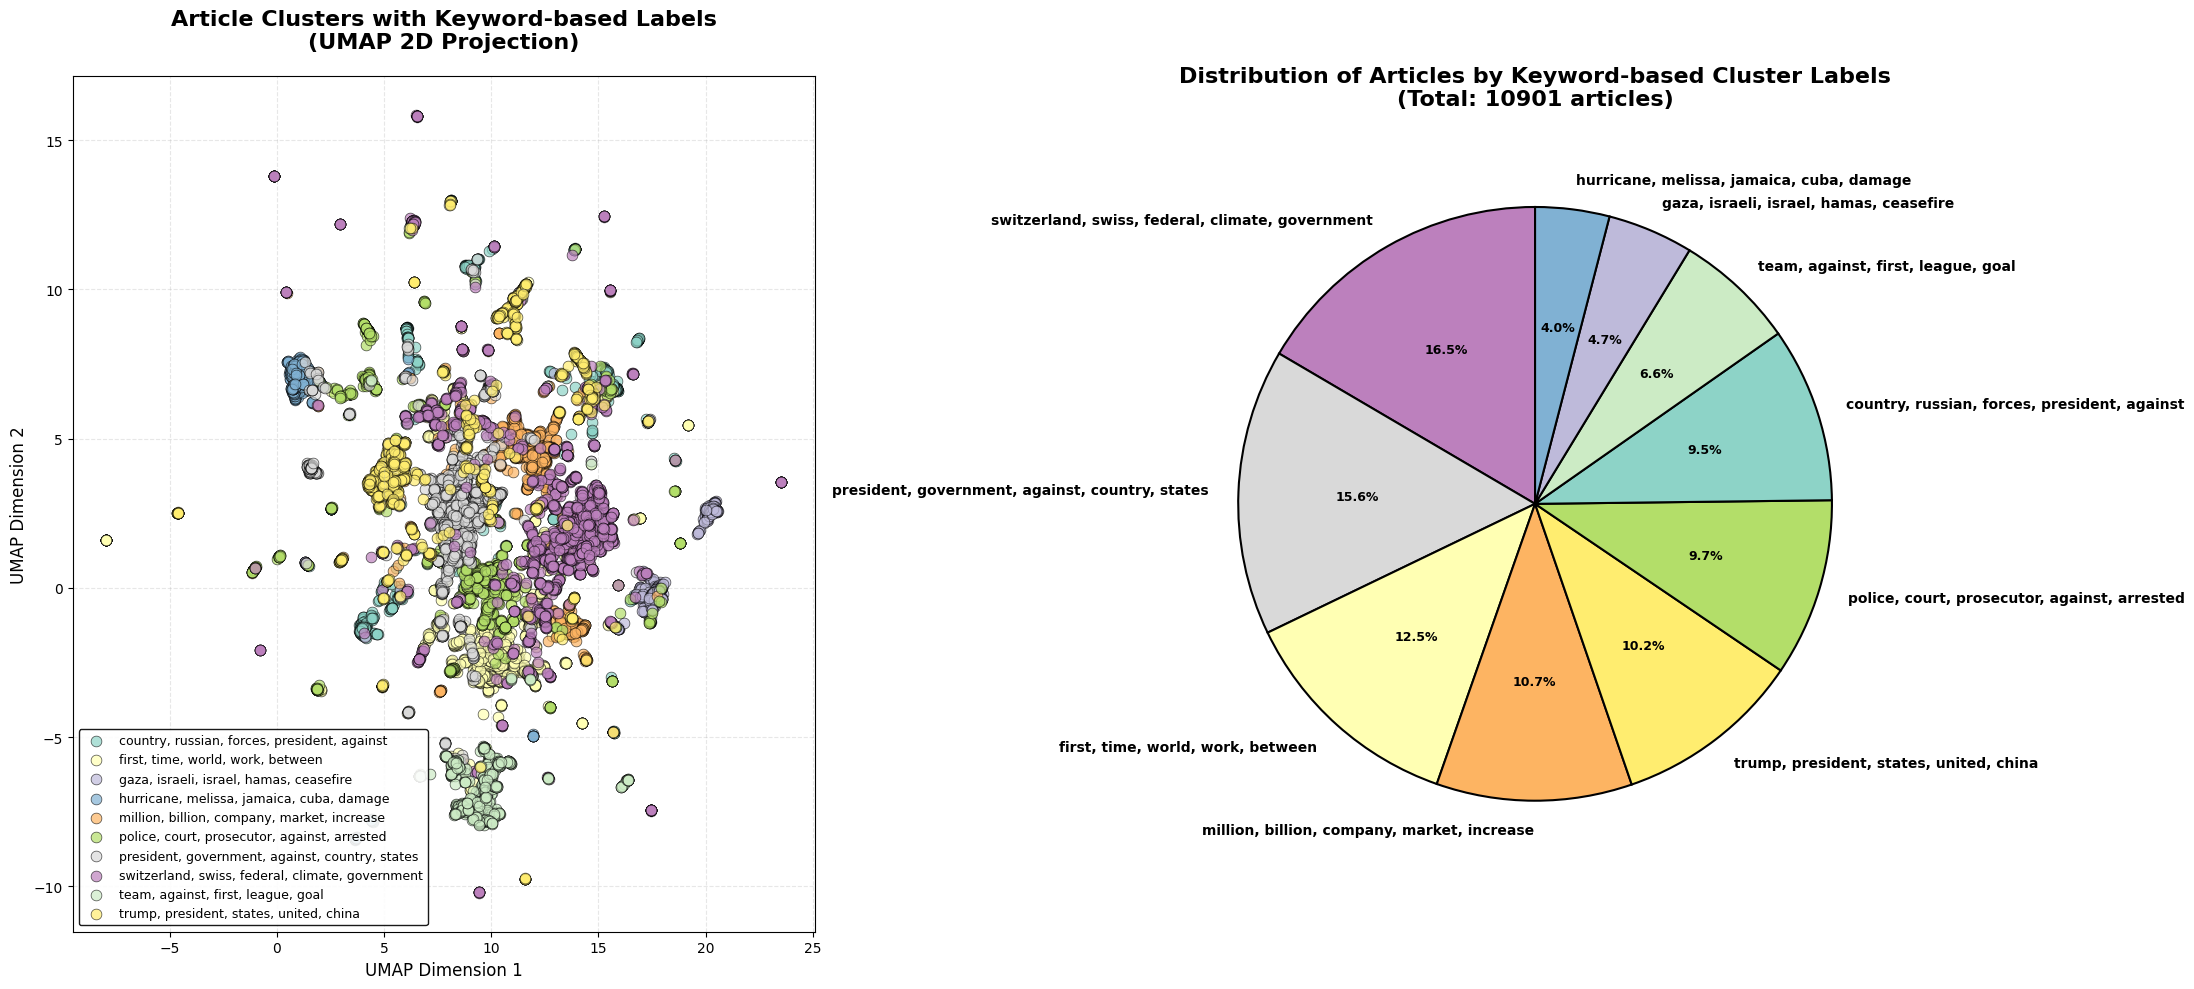

In [0]:
from umap import UMAP  # nur falls noch nicht importiert
import numpy as np
import matplotlib.pyplot as plt

# Create UMAP projection for translated text
reducer_en = UMAP(n_components=2, random_state=42, n_neighbors=15, min_dist=0.1)
embedding_2d_en = reducer_en.fit_transform(emb_matrix_en)

# Color map for keyword-based cluster labels
unique_labels = sorted(df_clusters_en["cluster_label_keywords"].unique())
category_colors = plt.cm.Set3(np.linspace(0, 1, len(unique_labels)))
category_color_map = {lab: color for lab, color in zip(unique_labels, category_colors)}

# Create visualization
fig = plt.figure(figsize=(22, 10))

# -----------------------------------
# Left: Scatter plot by label
# -----------------------------------
ax1 = plt.subplot(1, 2, 1)
for label in unique_labels:
    mask = df_clusters_en["cluster_label_keywords"] == label
    indices = df_clusters_en[mask].index

    ax1.scatter(
        embedding_2d_en[indices, 0],
        embedding_2d_en[indices, 1],
        c=[category_color_map[label]],
        label=label,
        alpha=0.7,
        s=60,
        edgecolors="black",
        linewidths=0.5,
    )

ax1.set_title(
    "Article Clusters with Keyword-based Labels\n(UMAP 2D Projection)",
    fontsize=16,
    fontweight="bold",
    pad=20,
)
ax1.set_xlabel("UMAP Dimension 1", fontsize=12)
ax1.set_ylabel("UMAP Dimension 2", fontsize=12)
ax1.legend(loc="best", fontsize=9, framealpha=0.9, edgecolor="black")
ax1.grid(True, alpha=0.3, linestyle="--")

# -----------------------------------
# Right: Pie chart by label
# -----------------------------------
ax2 = plt.subplot(1, 2, 2)
label_counts = df_clusters_en["cluster_label_keywords"].value_counts()
colors = [category_color_map[lab] for lab in label_counts.index]

wedges, texts, autotexts = ax2.pie(
    label_counts.values,
    labels=label_counts.index,
    autopct="%1.1f%%",
    startangle=90,
    colors=colors,
    textprops={"fontsize": 10, "weight": "bold"},
    wedgeprops={"edgecolor": "black", "linewidth": 1.5},
)

for autotext in autotexts:
    autotext.set_color("black")
    autotext.set_fontsize(9)

ax2.set_title(
    "Distribution of Articles by Keyword-based Cluster Labels\n"
    + f"(Total: {len(df_clusters_en)} articles)",
    fontsize=16,
    fontweight="bold",
    pad=20,
)

plt.tight_layout()
plt.show()


## 5.2 Method B: BERTopic (Custom Embeddings, UMAP & HDBSCAN)

This section implements a more advanced, fully unsupervised topic-modeling workflow using **BERTopic**, combining state-of-the-art embeddings with density-based clustering and automated topic extraction. Compared to K-means, this method adapts dynamically to the structure of the corpus. This BERTopic pipeline delivers a flexible and scalable method for identifying themes in large-scale news corpora, allowing for more adaptive and data-driven topic discovery than fixed-cluster K-means.


### 5.2.1 BERTopic Pipeline with Custom Embeddings, UMAP Reduction, and HDBSCAN Clustering

This section builds a complete BERTopic pipeline using a **custom embedding model**, UMAP dimensionality reduction, and HDBSCAN density-based clustering to extract robust and interpretable topics from the translated text corpus. The main components are:

- **Custom Embedding Class**:  
  A lightweight wrapper is implemented to generate sentence embeddings using the `nvidia/llama-embed-nemotron-8b` model.  
  - Texts are tokenized, padded, and truncated to 512 tokens.  
  - The model computes contextual embeddings, and the mean-pooled token representations form the final sentence vectors.  
  This ensures compatibility with BERTopic and gives full control over embedding generation.

- **Model & Data Loading**:  
  The NVIDIA model is loaded with automatic device placement for efficient GPU execution. All translated article texts are retrieved and prepared for processing.

- **UMAP Configuration**:  
  UMAP reduces the high-dimensional embedding space into 5 components using cosine distance.  
  - `n_neighbors` controls the balance between local and global structure,  
  - `min_dist` adjusts clustering tightness,  
  - `random_state` ensures reproducibility.

- **HDBSCAN Clustering Setup**:  
  HDBSCAN groups articles into dense semantic regions without requiring a predefined number of clusters.  
  - `min_cluster_size` determines the minimum topic size,  
  - `min_samples` controls how conservative clustering is,  
  - `cluster_selection_method='eom'` identifies stable topic regions.

- **BERTopic Assembly**:  
  BERTopic is created using:  
  - the custom embedder,  
  - the configured UMAP and HDBSCAN models,  
  - a CountVectorizer with customised stopwords.  
  This pipeline enables nuanced topic discovery across a large multilingual corpus.

- **Topic Modeling Execution**:  
  The model is trained on all documents, returning both topic assignments and cluster probabilities.  
  Topics are added back to the cleaned DataFrame for further analysis.

- **Results & Inspection**:  
  A summary of discovered topics is printed, including:  
  - number of topics,  
  - topic metadata table,  
  - sample articles with their assigned topics.  
  This allows rapid evaluation of topic quality and interpretability.

This workflow provides a scalable and highly configurable approach to topic modeling that leverages state-of-the-art embeddings and modern clustering techniques to uncover meaningful thematic structures in the news corpus.


In [0]:
import os
import torch
import pandas as pd
from bertopic import BERTopic
from umap import UMAP
from hdbscan import HDBSCAN
from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS
from transformers import AutoTokenizer, AutoModel

# =============================================================================
# CONFIG
# =============================================================================
RERUN_BERTOPIC = False  # <-- auf True setzen, wenn du NEU fitten willst

TOPIC_MODEL_DIR = "bertopic_nemotron_model"
DF_TOPICS_PATH = "articles_with_topics.parquet"

# =============================================================================
# CUSTOM EMBEDDER
# =============================================================================
class CustomEmbedder:
    def __init__(self, model, tokenizer):
        self.model = model
        self.tokenizer = tokenizer
    
    def encode(self, texts, **kwargs):
        inputs = self.tokenizer(
            texts,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=512,
        )
        inputs = {k: v.to(self.model.device) for k, v in inputs.items()}
        with torch.no_grad():
            outputs = self.model(**inputs)
            embeddings = outputs.last_hidden_state.mean(dim=1)
        return embeddings.cpu().numpy()

# =============================================================================
# MAIN LOGIC: ENTWEDER NEU BERECHNEN ODER LADEN
# =============================================================================
def build_or_load_bertopic_model(df_translated):
    """Build BERTopic model if necessary, otherwise load from disk."""
    should_recompute = (
        RERUN_BERTOPIC
        or not os.path.exists(TOPIC_MODEL_DIR)
        or not os.path.exists(DF_TOPICS_PATH)
    )
    
    if should_recompute:
        # ---------------------------------------------------------------------
        # 1) Modell + Daten laden
        # ---------------------------------------------------------------------
        print("Recomputing BERTopic model...")

        print("Loading embedding model...")
        MODEL_NAME = "nvidia/llama-embed-nemotron-8b"
        tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, trust_remote_code=True)
        model = AutoModel.from_pretrained(
            MODEL_NAME,
            torch_dtype=torch.float16,
            device_map="auto",
            trust_remote_code=True,
        )
        print(f"✓ Loaded {MODEL_NAME}")

        print("\nLoading data...")
        df = df_translated.copy()
        df = df.dropna(subset=["content_text_en"]).reset_index(drop=True)
        docs = df["content_text_en"].tolist()
        print(f"✓ Loaded {len(docs)} documents")

        # ---------------------------------------------------------------------
        # 2) UMAP + HDBSCAN konfigurieren
        # ---------------------------------------------------------------------
        umap_model = UMAP(
            n_neighbors=20,
            n_components=5,
            min_dist=0.0,
            metric="cosine",
            random_state=42,
        )

        hdbscan_model = HDBSCAN(
            min_cluster_size=220,
            min_samples=15,
            metric="euclidean",
            cluster_selection_method="eom",
            prediction_data=True,
        )

        print("\nSetting up BERTopic...")
        embedding_model = CustomEmbedder(model, tokenizer)

        custom_stopwords = list(ENGLISH_STOP_WORDS) + ["said", "efe"]
        vectorizer_model = CountVectorizer(stop_words=custom_stopwords)

        topic_model = BERTopic(
            embedding_model=embedding_model,
            umap_model=umap_model,
            hdbscan_model=hdbscan_model,
            vectorizer_model=vectorizer_model,
            verbose=True,
        )
        print("✓ BERTopic configured")

        # ---------------------------------------------------------------------
        # 3) Fit + Transform
        # ---------------------------------------------------------------------
        print("\nRunning topic modeling...")
        topics, probs = topic_model.fit_transform(docs)

        df_clean = df.copy()
        df_clean["topic"] = topics

        # ---------------------------------------------------------------------
        # 4) Speichern
        # ---------------------------------------------------------------------
        df_clean.to_parquet(DF_TOPICS_PATH, index=False)
        topic_model.save(TOPIC_MODEL_DIR)

        print(f"\n✓ Saved articles with topics to: {DF_TOPICS_PATH}")
        print(f"✓ Saved BERTopic model to: {TOPIC_MODEL_DIR}")

    else:
        # ---------------------------------------------------------------------
        # NUR LADEN
        # ---------------------------------------------------------------------
        print("Loading existing BERTopic model and topics from disk...")
        topic_model = BERTopic.load(TOPIC_MODEL_DIR)
        df_clean = pd.read_parquet(DF_TOPICS_PATH)
        print("✓ Loaded existing model and topic assignments")

    return topic_model, df_clean

# =============================================================================
# AUSFÜHREN
# =============================================================================
topic_model, df_clean = build_or_load_bertopic_model(df_translated)

# =============================================================================
# AUSGABEN / DIAGNOSTIK
# =============================================================================
print(f"\n{'='*60}")
print(f"RESULTS: Found {len(set(df_clean['topic']))} topics")
print(f"{'='*60}\n")

topic_info = topic_model.get_topic_info()
display(topic_info)

print(f"\n{'='*60}")
print("SAMPLE ARTICLES WITH TOPICS")
print(f"{'='*60}\n")
display(df_clean[["content_text_en", "topic"]].head(10))


Loading existing BERTopic model and topics from disk...
✓ Loaded existing model and topic assignments

RESULTS: Found 10 topics



,Topic,Count,Name,Representation,Representative_Docs
0,-1,1559,-1_police_people_according_government,"[police, people, according, government, rio, p...",[Scenes of war in Rio de Janeiro: 64 dead in t...
1,0,3445,0_president_trump_states_united,"[president, trump, states, united, year, count...","[Dominated by Xi, the APEC summit closes with ..."
2,1,1276,1_switzerland_swiss_initiative_tax,"[switzerland, swiss, initiative, tax, people, ...",[Even those of Swiss descent cannot stay after...
3,2,879,2_gaza_israeli_israel_hamas,"[gaza, israeli, israel, hamas, ceasefire, al, ...",[Israel receives the remains of another hostag...
4,3,821,3_ai_intelligence_film_new,"[ai, intelligence, film, new, artificial, swis...","[Switzerland aspires to ""human"" artificial int..."
5,4,811,4_team_league_match_goal,"[team, league, match, goal, game, points, seas...",[Leader Davos inflicts the Lakers' 6th defeat ...
6,5,626,5_russian_nuclear_ukraine_russia,"[russian, nuclear, ukraine, russia, ukrainian,...",[Trump orders the resumption of nuclear weapon...
7,6,617,6_police_court_prosecutor_old,"[police, court, prosecutor, old, year, arreste...",[Two of the five people arrested on Wednesday ...
8,7,537,7_hurricane_melissa_jamaica_cuba,"[hurricane, melissa, jamaica, cuba, people, da...",[Hurricane Melissa hit Jamaica hard with winds...
9,8,330,8_trump_mamdani_new_york,"[trump, mamdani, new, york, democratic, democr...",[Mamdani became mayor of New York on a night o...



SAMPLE ARTICLES WITH TOPICS



,content_text_en,topic
0,“Buonanotte” was a broadcast on an independent...,3
1,Crime affects large businessmen in Peru and be...,0
2,FinnLAC emphasizes that an efficient fintech e...,0
3,Widow of mayor murdered in Mexico takes office...,0
4,Dominican Republic strengthens the competitive...,0
5,Snapchat's parent company announces an AI agre...,0
6,"Brazil, Colombia and Mexico dominate athletics...",4
7,Judge orders ICE to improve 'inhumane' conditi...,0
8,Asian Stocks Set to Rise After Wall Street Gai...,0
9,Copom maintains Selic at 15% The Central Bank'...,0


In [0]:
for topic_id in topic_info['Topic']:
    if topic_id == -1:
        continue
    keywords = topic_model.get_topic(topic_id)
    if keywords:
        keywords_str = ', '.join([word for word, _ in keywords])
        print(f"Topic {topic_id}: {keywords_str}")
    else:
        print(f"Topic {topic_id}: (no keywords)")
if -1 in topic_info['Topic'].values:
    keywords = topic_model.get_topic(-1)
    if keywords:
        keywords_str = ', '.join([word for word, _ in keywords])
        print(f"Topic -1: {keywords_str}")
    else:
        print("Topic -1: (no keywords)")

Topic 0: president, trump, states, united, year, country, china, government, according, meeting
Topic 1: switzerland, swiss, initiative, tax, people, federal, francs, new, council, canton
Topic 2: gaza, israeli, israel, hamas, ceasefire, al, army, palestinian, strip, fasher
Topic 3: ai, intelligence, film, new, artificial, swiss, music, like, human, time
Topic 4: team, league, match, goal, game, points, season, minute, cup, games
Topic 5: russian, nuclear, ukraine, russia, ukrainian, nato, tests, drones, military, weapons
Topic 6: police, court, prosecutor, old, year, arrested, prison, man, louvre, according
Topic 7: hurricane, melissa, jamaica, cuba, people, damage, category, winds, storm, island
Topic 8: trump, mamdani, new, york, democratic, democrats, shutdown, republican, government, republicans
Topic -1: police, people, according, government, rio, president, switzerland, party, country, operation


### 5.2.2 Exporting Topic-Enhanced Articles to CSV

In this final step, the clustered articles are prepared for export by attaching human-readable topic labels and writing the enriched dataset to a CSV file. The process includes:

- **Custom Topic Label Definition**:  
  A dictionary maps each numerical topic ID (including the outlier cluster `-1`) to a descriptive thematic label.  
  These labels provide clearer interpretations, such as *Swiss Domestic Affairs & Policy* or *Middle East Conflict & Humanitarian Issues*.

- **Label Assignment**:  
  Each article's assigned topic ID is matched with its corresponding descriptive label and written into a new column (`topic_label`).  
  This enhances readability and makes the dataset suitable for reporting, dashboards, or editorial review.

- **Export to CSV**:  
  The full dataset—containing article text, topic IDs, and descriptive topic labels—is exported as `articles_with_topics.csv`.  
  UTF-8 encoding ensures compatibility across analytical tools and platforms.

This export step provides a clean, labelled dataset ready for downstream analysis, sharing with stakeholders, or integration into BI tools such as Power BI or Databricks SQL dashboards.


In [0]:
# ============================================================================
# SAVE RESULTS TO CSV
# ============================================================================
print("\nPreparing data for export...")

# Helper: build a label from the top N BERTopic keywords
def make_topic_label(topic_id, topic_model, top_k: int = 5) -> str:
    """Create a short label from the top_k words of a BERTopic topic."""
    if pd.isna(topic_id):
        return "Unknown"
    topic_id_int = int(topic_id)

    if topic_id_int == -1:
        return "Outliers / Miscellaneous"

    words = topic_model.get_topic(topic_id_int)
    if not words:
        return f"Topic {topic_id_int}"

    top_words = [w for w, _ in words[:top_k]]
    return ", ".join(top_words)

# Create topic_label column directly from BERTopic model
df_clean["topic_label"] = df_clean["topic"].apply(
    lambda t: make_topic_label(t, topic_model, top_k=5)
)

# Save all articles with topics
output_file = "articles_with_topics.csv"
df_clean.to_csv(output_file, index=False, encoding="utf-8")
print(f"✓ Saved all articles to: {output_file}")



Preparing data for export...
✓ Saved all articles to: articles_with_topics.csv


### 5.2.3 Visualizing Topic Distribution Across the Corpus

This step generates a clean and interpretable visualization of how frequently each topic appears within the full article dataset. The process includes:

- **Topic Share Calculation**:  
  Each article’s descriptive topic label is counted, and the relative frequency (in percent) of each topic is computed.  
  Sorting the percentages from smallest to largest ensures that less common topics remain visible in the final chart.

- **Horizontal Bar Chart Construction**:  
  A horizontal bar plot is created to display the percentage share of each topic category.  
  - A smooth **viridis** color palette is applied for a visually appealing gradient.  
  - Each bar represents one topic, and the length corresponds to its share of the corpus.

- **Bar Labeling & Styling**:  
  Percentage labels are added directly next to each bar for easy interpretation.  
  The chart uses minimalist styling—hidden top/right spines and subtle gridlines—to keep attention on the distribution itself.

- **Exporting the Chart**:  
  The final visualization is saved as a high-resolution PNG file (`topic_distribution.png`), making it suitable for presentations, reports, or dashboards.

This visual summary provides a quick overview of dominant and niche themes in the corpus, helping stakeholders understand topic prevalence at a glance.


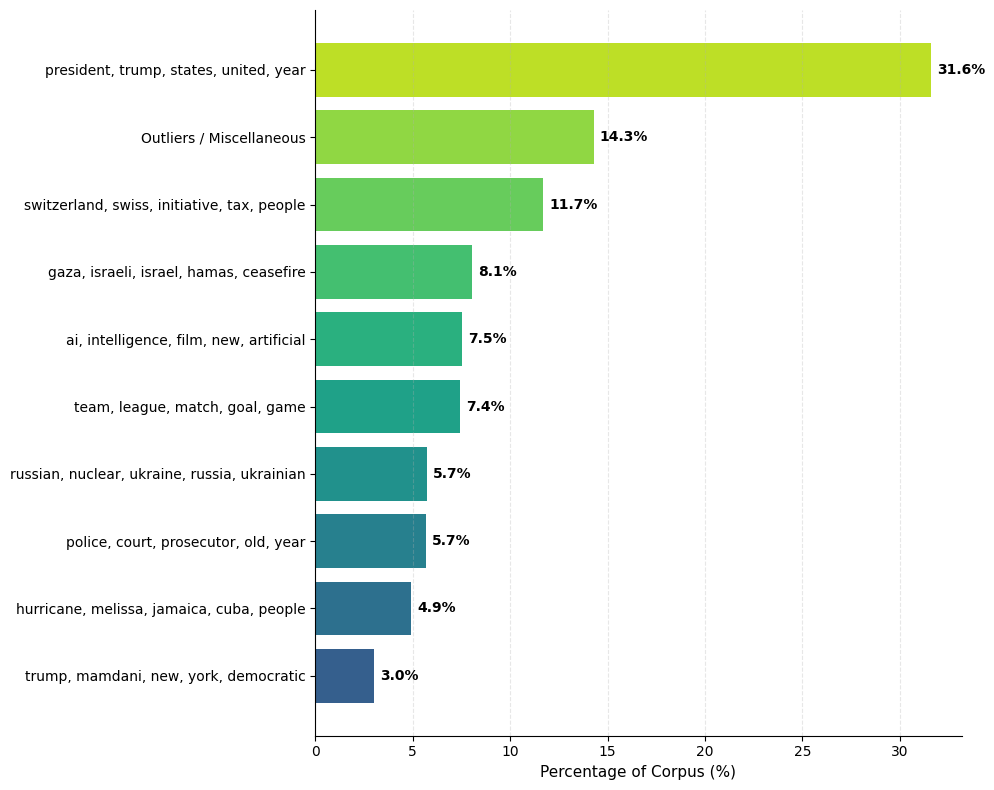

✓ Saved chart to: topic_distribution.png


In [0]:
# Calculate topic percentages
topic_counts = df_clean['topic_label'].value_counts()
topic_percentages = (topic_counts / len(df_clean) * 100).sort_values(ascending=True)

# Create horizontal bar chart
fig, ax = plt.subplots(figsize=(10, 8))

# Use a nice color palette (viridis, but you can try: 'plasma', 'cividis', 'coolwarm')
colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(topic_percentages)))

bars = ax.barh(topic_percentages.index, topic_percentages.values, color=colors)

# Add bar labels
for i, (bar, value) in enumerate(zip(bars, topic_percentages.values)):
    ax.text(value + 0.3, i, f'{value:.1f}%', 
            va='center', fontsize=10, fontweight='bold')

# Minimal styling
ax.set_xlabel('Percentage of Corpus (%)', fontsize=11)
ax.set_ylabel('')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='x', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig('topic_distribution.png', dpi=300, bbox_inches='tight')
plt.show()
print(f"✓ Saved chart to: topic_distribution.png")

### 5.2.4 Topic Trends Over Time – Small Multiples

This section analyses how topic prevalence evolves over time and visualises daily article counts per topic using a **compact small-multiples layout**. The goal is to detect temporal patterns, spikes, and event-driven dynamics across topics. The workflow consists of:

- **Data Loading and Date Parsing**:  
  The enriched dataset `articles_with_topics.csv` is loaded, and publication timestamps (`releaseDate`) are converted into proper datetime objects.  
  A simplified `date` column (YYYY-MM-DD) is created to aggregate articles at daily resolution.

- **Topic Ordering and Outlier Handling**:  
  Total article counts per `topic_label` are computed and used to sort topics by overall importance.  
  Any outlier category (e.g. *Outliers / Unassigned*) is detected and placed at the end of the visualisation to keep focus on meaningful topics.

- **Daily Topic Aggregation**:  
  The number of articles per topic and per day is calculated, resulting in a time series for each topic across the selected date range (here: 27 October 2025 to 5 November 2025).

- **Small Multiples Line Charts**:  
  For each topic, a separate small line chart is drawn in a grid layout:  
  - Daily counts are plotted as a line with markers,  
  - A shared y-axis scale is derived from the global maximum to allow visual comparison across panels,  
  - Each subplot includes a compact title and a legend indicating the **total** number of articles for that topic.

- **Axis Formatting and Export**:  
  Dates on the x-axis are displayed in a short `MM-DD` format with a two-day interval for readability.  
  The final multi-panel figure is saved as `topics_over_time_small_multiples.png`, ready for use in reports or presentations.

These compact small multiples make it easy to compare temporal dynamics across topics, highlight news-driven peaks, and identify which themes are persistent versus event-specific in the corpus.


Loading data...
✓ Loaded 10901 articles
Date range: 2012-12-11 20:46:13 to 2025-11-05 23:58:57

Creating compact small multiples chart...
✓ Saved: topics_over_time_small_multiples.png


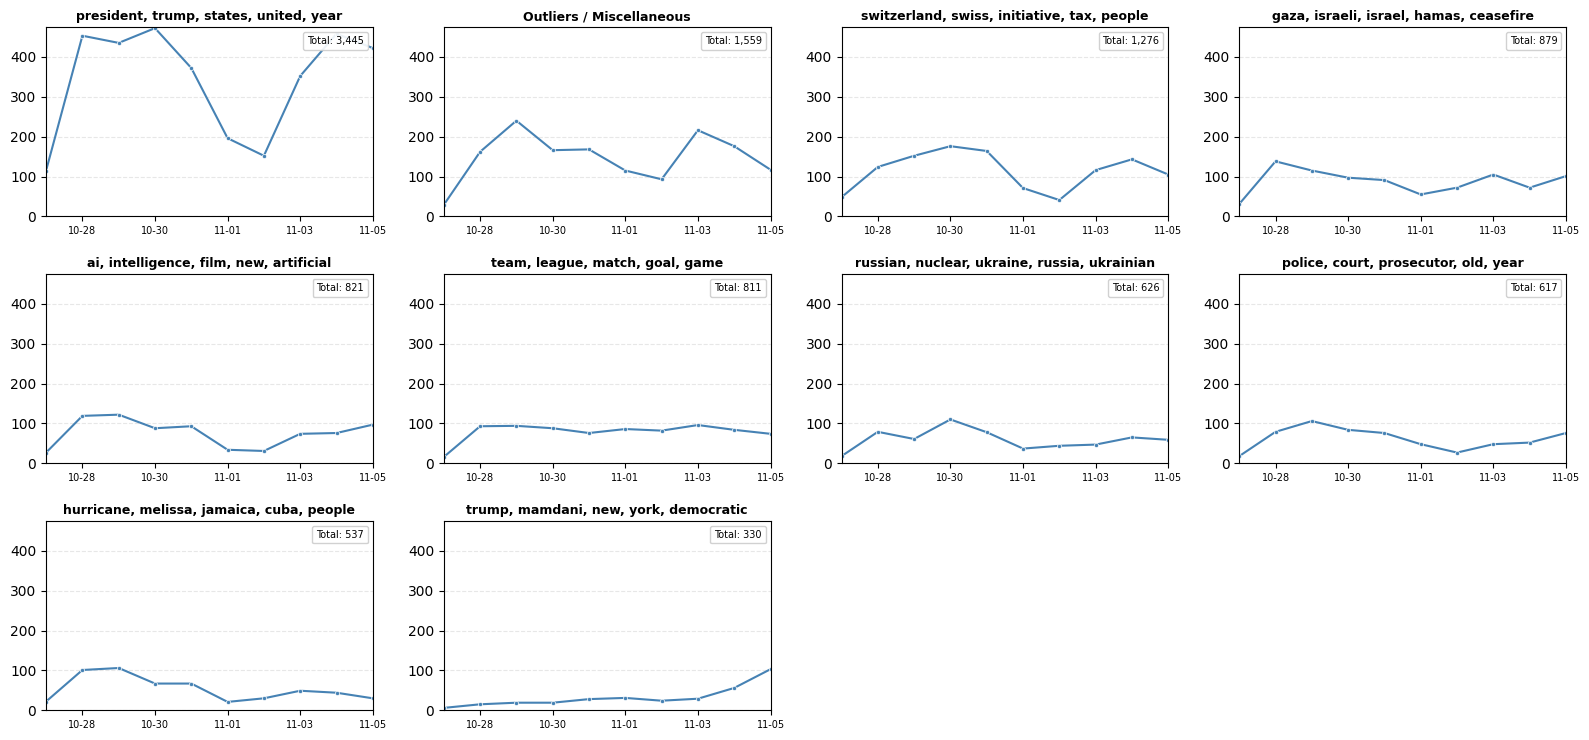

In [0]:
# ============================================================================
# TOPIC COUNTS OVER TIME - SMALL MULTIPLES (COMPACT)
# ============================================================================
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime

# ============================================================================
# LOAD DATA
# ============================================================================
print("Loading data...")
df = pd.read_csv("articles_with_topics.csv")
print(f"✓ Loaded {len(df)} articles")

# Parse dates
df['releaseDate'] = pd.to_datetime(df['releaseDate'])
df['date'] = df['releaseDate'].dt.date
print(f"Date range: {df['releaseDate'].min()} to {df['releaseDate'].max()}")

# Set date limits for x-axis
date_min = datetime(2025, 10, 27)
date_max = datetime(2025, 11, 5)

# ============================================================================
# PREPARE DATA
# ============================================================================
# Calculate total counts per topic
topic_totals = df.groupby('topic_label').size().reset_index(name='total')
topic_totals = topic_totals.sort_values('total', ascending=False)

# Separate outliers from other topics
outliers_mask = topic_totals['topic_label'] == 'Outliers / Unassigned'
outliers_topic = topic_totals[outliers_mask]['topic_label'].tolist()
other_topics = topic_totals[~outliers_mask]['topic_label'].tolist()

# Combine: sorted topics + outliers at the end
topics = other_topics + outliers_topic

daily_counts = df.groupby(['topic_label', 'date']).size().reset_index(name='count')

# ============================================================================
# CREATE SMALL MULTIPLES (COMPACT)
# ============================================================================
print("\nCreating compact small multiples chart...")
n_topics = len(topics)
n_cols = 4  # More columns = more compact
n_rows = (n_topics + n_cols - 1) // n_cols

# Reduced figure size
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 2.5*n_rows))
axes = axes.flatten() if n_rows > 1 else axes

for idx, topic in enumerate(topics):
    ax = axes[idx]
    
    topic_data = daily_counts[daily_counts['topic_label'] == topic].copy()
    topic_data = topic_data.sort_values('date')
    topic_data['date'] = pd.to_datetime(topic_data['date'])
    
    # Calculate total
    total = topic_data['count'].sum()
    
    # Plot with label for legend
    ax.plot(topic_data['date'], topic_data['count'], 
            color='steelblue', linewidth=1.5, marker='o', markersize=3, 
            markerfacecolor='steelblue', markeredgecolor='white', markeredgewidth=0.5,
            label=f'Total: {total:,}')
    
    # Smaller title with less padding
    ax.set_title(topic, fontsize=9, fontweight='bold', pad=5)
    
    # Set a flexible, shared y-limit for all plots based on the global max
    global_max = daily_counts['count'].max()
    y_max = int((global_max + 24) // 25 * 25)  # round up to next 25
    ax.set_ylim(0, y_max)
    
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    
    # Format x-axis
    ax.set_xlim(date_min, date_max)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))  # Shorter date format
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
    plt.setp(ax.xaxis.get_majorticklabels(), fontsize=7)
    
    # Add legend (text only, no marker or line)
    ax.legend(loc='upper right', fontsize=7, framealpha=0.9, handlelength=0, handletextpad=0, markerscale=0)

for idx in range(n_topics, len(axes)):
    axes[idx].axis('off')

plt.tight_layout(h_pad=1.5, w_pad=1.5)
plt.savefig('topics_over_time_small_multiples.png', dpi=300, bbox_inches='tight')
print("✓ Saved: topics_over_time_small_multiples.png")
plt.show()
plt.close()

## 5.3 Method Comparison: K-means vs. BERTopic

This section compares the two topic modeling approaches applied to the same article corpus:

- **Method A – K-means**  
  - Fixed number of clusters (e.g. *k = 10*)  
  - Centroid-based partitioning of MiniLM embeddings  
  - Topics inferred via keyword extraction and manual labeling  
  - Simpler, faster, but less flexible regarding cluster shape and number

- **Method B – BERTopic (UMAP + HDBSCAN)**  
  - Uses custom LLaMA-based embeddings  
  - Reduces dimensionality with UMAP  
  - Finds dense regions with HDBSCAN (no fixed k)  
  - Automatically extracts topic terms and allows custom labeling  
  - More adaptive to corpus structure and outliers


### 5.3.1 Comparing the Output (Clusters / Topics)

In [0]:
# Merge K-means cluster info and BERTopic info into original df_translated

# Ensure 'id' is present in all DataFrames
df_kmeans = df_clusters_en[['id', 'cluster', 'cluster_topic']]
df_kmeans = df_kmeans.rename(columns={
    'cluster': 'kmeans_cluster',
    'cluster_topic': 'kmeans_cluster_topic',
    'topic_category_enhanced': 'kmeans_topic_category_enhanced',
    'topic_category_highlevel': 'kmeans_topic_category_highlevel'
})

df_bertopic = df_clean[['id', 'topic', 'topic_label']]
df_bertopic = df_bertopic.rename(columns={
    'topic': 'bertopic_topic',
    'topic_label': 'bertopic_topic_label'
})

# Merge K-means clusters
df_merged = pd.DataFrame(df_translated).merge(df_kmeans, on='id', how='left')

# Merge BERTopic topics
df_merged = df_merged.merge(df_bertopic, on='id', how='left')

In [0]:
df_clusters_en

,id,original_text,translated_text_en,cluster,cluster_topic,cluster_label_keywords
0,urn:pdp:cue_rsi:article:rsi:cue:story:3238385,“Buonanotte” era una trasmissione di una radio...,“Buonanotte” was a broadcast on an independent...,3,NaN,"first, time, world, work, between"
1,urn:pdp:cms_swi:article:90286862,La criminalidad afecta a grandes empresarios d...,Crime affects large businessmen in Peru and be...,6,NaN,"president, government, against, country, states"
2,urn:pdp:cms_swi:article:90286861,FinnLAC subraya que un ecosistema fintech efic...,FinnLAC emphasizes that an efficient fintech e...,9,NaN,"million, billion, company, market, increase"
3,urn:pdp:cms_swi:article:90286860,Viuda de alcalde asesinado en México toma pose...,Widow of mayor murdered in Mexico takes office...,6,NaN,"president, government, against, country, states"
4,urn:pdp:cms_swi:article:90286857,República Dominicana fortalece la competitivid...,Dominican Republic strengthens the competitive...,6,NaN,"president, government, against, country, states"
...,...,...,...,...,...,...
10896,urn:pdp:cms_swi:article:90234897,La UE y China se ven esta semana para abordar ...,The EU and China meet this week to address Bei...,2,NaN,"trump, president, states, united, china"
10897,urn:pdp:cms_swi:article:90234463,Familiares de reféns exigem devolução de todos...,Relatives of hostages demand the return of all...,1,NaN,"gaza, israeli, israel, hamas, ceasefire"
10898,urn:pdp:cms_swi:article:90234896,Sheinbaum dice que México aún espera respuesta...,Sheinbaum says Mexico is still waiting for a r...,6,NaN,"president, government, against, country, states"
10899,urn:pdp:cms_srf:article:urn:srf:article:019a26...,Verschiedene Akteure des Schweizer Gesundheits...,Various players in the Swiss healthcare system...,0,NaN,"switzerland, swiss, federal, climate, government"


In [0]:
# A quick look at the data 
for _, row in df_merged.head(10).iterrows():
    print(f"ID: {row['id']}")
    print(f"Text: {str(row.get('content_text_en', ''))[:500]}")
    print(f"K-means Category: {row.get('kmeans_topic_category_enhanced', '')} | BERTopic Label: {row.get('bertopic_topic_label', '')}")
    print("-" * 80)

ID: urn:pdp:cue_rsi:article:rsi:cue:story:3238385
Text: “Buonanotte” was a broadcast on an independent radio station in Naples at the end of the 90s.It was a program of dedications, but absolutely not of loving thoughts between boyfriends: people who were free, sent greetings to relatives in prison.A typical dedication?"I'm Nunzia from Secondigliano. I send greetings to my husband Carmine, with him and his friends staying home very soon. Love, I love you!"On the “I love you” the host inserted a very long echo effect, which made everything more kitsch
K-means Category:  | BERTopic Label: ai, intelligence, film, new, artificial
--------------------------------------------------------------------------------
ID: urn:pdp:cms_swi:article:90286862
Text: Crime affects large businessmen in Peru and becomes their main concern Lima, Nov 5 (EFE).- Crime and insecurity has also become the main concern of large companies in Peru, which have already begun to be affected, with 13% declaring that they

In [0]:
# -------------------------------------------------------------------
# Helper: Extract top keywords for a BERTopic topic
# -------------------------------------------------------------------
def get_bertopic_keywords(topic_id, topic_model, top_n=10):
    """
    Return comma-separated keywords for a BERTopic topic.
    Handles missing topics, outliers (-1), and empty categories.
    """
    if topic_id is None or pd.isna(topic_id):
        return ""

    try:
        topic_id = int(topic_id)
    except:
        return ""

    # Outlier topic
    if topic_id == -1:
        return ""

    try:
        topic_words = topic_model.get_topic(topic_id)
    except KeyError:
        # Topic does not exist in model (can happen after caching)
        return ""

    if topic_words is None:
        return ""

    # Extract words only
    keywords = [word for word, _ in topic_words[:top_n]]
    return ", ".join(keywords)


In [0]:
import numpy as np
import pandas as pd

# ============================================================
# 0) Ensure helper objects exist
# ============================================================

# topic_labels_en: mapping K-means cluster_id -> keywords (list or string)
try:
    topic_labels_en
except NameError:
    with open(TOPIC_LABELS_PATH, "r") as f:
        topic_labels_en = json.load(f)

# ensure int keys
topic_labels_en = {int(k): v for k, v in topic_labels_en.items()}


# BERTopic: pretty labels (top-5 keywords) and keyword helper
try:
    bertopic_pretty_labels
except NameError:
    bertopic_pretty_labels = {}
    for topic_id in topic_model.get_topics().keys():
        if topic_id == -1:
            bertopic_prety_labels[topic_id] = "Outliers / Miscellaneous"
        else:
            words = topic_model.get_topic(topic_id)
            if not words:
                bertopic_pretty_labels[topic_id] = f"Topic {topic_id}"
            else:
                top_words = [w for w, _ in words[:5]]
                bertopic_pretty_labels[topic_id] = ", ".join(top_words)


def get_bertopic_keywords(topic_id, topic_model, top_n: int = 10) -> str:
    """Longer keyword list for a given BERTopic topic_id."""
    if topic_id == -1 or pd.isna(topic_id):
        return ""
    words = topic_model.get_topic(int(topic_id))
    if not words:
        return ""
    return ", ".join([w for w, _ in words[:top_n]])


# ============================================================
# Helper: auto-label K-means clusters with top keywords
# ============================================================

def make_kmeans_keyword_label(cluster_id, topic_labels_en, top_k: int = 5) -> str:
    if pd.isna(cluster_id):
        return ""
    cid = int(cluster_id)

    raw = topic_labels_en.get(cid, "")

    if isinstance(raw, (list, tuple)):
        keywords = [str(w) for w in raw][:top_k]
    elif isinstance(raw, str):
        parts = [p.strip() for p in raw.split(",") if p.strip()]
        keywords = parts[:top_k]
    else:
        keywords = [str(raw)]

    return ", ".join(keywords)


# ============================================================
# 1) K-means – compact overview
# ============================================================

# 1) Size per cluster
cluster_sizes = (
    df_merged
    .groupby("kmeans_cluster")
    .size()
    .rename("num_articles")
)

# 2) Dominant BERTopic topic per cluster
dominant_bertopic = (
    df_merged
    .groupby("kmeans_cluster")["bertopic_topic"]
    .agg(lambda s: s.value_counts().idxmax() if s.notna().any() else np.nan)
    .rename("dominant_bertopic_topic")
)

df_kmeans_overview = (
    pd.concat([cluster_sizes, dominant_bertopic], axis=1)
    .reset_index()
    .rename(columns={"kmeans_cluster": "cluster_id"})
)

# 3) Auto-label K-means clusters with top keywords
df_kmeans_overview["kmeans_label"] = df_kmeans_overview["cluster_id"].apply(
    lambda cid: make_kmeans_keyword_label(cid, topic_labels_en)
)

# 4) Dominant BERTopic label (top-5 keyword label)
df_kmeans_overview["dominant_bertopic_label"] = df_kmeans_overview["dominant_bertopic_topic"].map(
    bertopic_pretty_labels
)

df_kmeans_final = df_kmeans_overview[
    ["kmeans_label", "num_articles", "dominant_bertopic_label"]
].sort_values("num_articles", ascending=False)

print("=== K-means – Final Compact Overview ===")
display(df_kmeans_final)


# ============================================================
# 2) BERTopic – compact overview
# ============================================================

# 1) Size per BERTopic topic
topic_sizes = (
    df_merged
    .groupby("bertopic_topic")
    .size()
    .rename("num_articles")
)

# 2) Dominant K-means per topic
dominant_kmeans = (
    df_merged
    .groupby("bertopic_topic")["kmeans_cluster"]
    .agg(lambda s: s.value_counts().idxmax() if s.notna().any() else np.nan)
    .rename("dominant_kmeans_cluster")
)

df_bertopic_overview = (
    pd.concat([topic_sizes, dominant_kmeans], axis=1)
    .reset_index()
    .rename(columns={"bertopic_topic": "topic_id"})
)

# 3) BERTopic labels + keywords
df_bertopic_overview["bertopic_label"] = df_bertopic_overview["topic_id"].map(
    bertopic_pretty_labels
)

df_bertopic_overview["bertopic_keywords"] = df_bertopic_overview["topic_id"].apply(
    lambda t: get_bertopic_keywords(t, topic_model, top_n=10)
)

# 4) Dominant K-means label (keyword-based)
df_bertopic_overview["dominant_kmeans_label"] = df_bertopic_overview["dominant_kmeans_cluster"].apply(
    lambda cid: make_kmeans_keyword_label(cid, topic_labels_en)
)

df_bertopic_final = df_bertopic_overview[
    ["bertopic_label", "num_articles", "dominant_kmeans_label"]
].sort_values("num_articles", ascending=False)

print("=== BERTopic – Final Compact Overview ===")
display(df_bertopic_final)


=== K-means – Final Compact Overview ===


,kmeans_label,num_articles,dominant_bertopic_label
0,"switzerland, swiss, federal, climate, government",5880,NaN
3,"first, time, world, work, between",5069,NaN
8,"police, court, prosecutor, against, arrested",4094,NaN
1,"gaza, israeli, israel, hamas, ceasefire",2993,NaN
2,"trump, president, states, united, china",2829,NaN
5,"country, russian, forces, president, against",2306,NaN
7,"team, against, first, league, goal",2045,NaN
6,"president, government, against, country, states",2006,NaN
9,"million, billion, company, market, increase",1827,NaN
4,"hurricane, melissa, jamaica, cuba, damage",1010,NaN


=== BERTopic – Final Compact Overview ===


,bertopic_label,num_articles,dominant_kmeans_label
0,NaN,7620,"police, court, prosecutor, against, arrested"
3,NaN,4851,"gaza, israeli, israel, hamas, ceasefire"
1,NaN,4607,"president, government, against, country, states"
2,NaN,3509,"switzerland, swiss, federal, climate, government"
5,NaN,2239,"team, against, first, league, goal"
6,NaN,2210,"country, russian, forces, president, against"
4,NaN,2181,"first, time, world, work, between"
7,NaN,1183,"police, court, prosecutor, against, arrested"
8,NaN,1137,"hurricane, melissa, jamaica, cuba, damage"
9,NaN,522,"trump, president, states, united, china"


####Key Findings

---

**K-means Cluster Labels (10 Clusters):**  
*K-means produces broader, more general thematic groupings based on centroid-based clustering.*

- **Cluster 0:** Swiss Domestic Politics, Society & Climate Policy  
  *Keywords: switzerland, federal, climate, council*
- **Cluster 1:** Middle East Conflict (Gaza & Israel)  
  *Keywords: gaza, israeli, hamas, ceasefire*
- **Cluster 2:** US–China Geopolitics & International Diplomacy  
  *Keywords: trump, states, china, meeting*
- **Cluster 3:** Global Culture, Lifestyle & Human Interest Stories  
  *Keywords: film, world, life, music*
- **Cluster 4:** Natural Disasters – Hurricanes & Caribbean Impact  
  *Keywords: hurricane, melissa, jamaica*
- **Cluster 5:** Russia–Ukraine Conflict & International Military Affairs  
  *Keywords: russian, forces, city, government*
- **Cluster 6:** Latin American Politics, Security & Government Affairs  
  *Keywords: venezuela, police, drug, president*
- **Cluster 7:** International Sports News & Competitions  
  *Keywords: team, league, match*
- **Cluster 8:** Crime, Justice & Law Enforcement  
  *Keywords: police, court, arrested*
- **Cluster 9:** Global Economy, Markets & Corporate Finance  
  *Keywords: company, market, billion*

---

**BERTopic Labels (9 Topics + Outliers):**  
*BERTopic yields more fine-grained, semantically nuanced topic structures.*

- **Topic 0:** US–China Diplomacy & International Politics  
  *Keywords: president, trump, china, government*
- **Topic 1:** Swiss Domestic Politics, Initiatives & Fiscal Policy  
  *Keywords: swiss, tax, federal, canton*
- **Topic 2:** Gaza War & Middle East Humanitarian Crisis  
  *Keywords: gaza, hamas, ceasefire*
- **Topic 3:** AI, Film, Arts & Tech-Driven Culture  
  *Keywords: ai, film, music, artificial*
- **Topic 4:** Sports – Football, Matches, Leagues  
  *Keywords: team, league, goal*
- **Topic 5:** Russia–Ukraine War & Military Technology  
  *Keywords: russian, ukraine, nato, military*
- **Topic 6:** Crime, Courts & Law Enforcement  
  *Keywords: police, court, arrested*
- **Topic 7:** Hurricanes & Severe Weather in the Caribbean  
  *Keywords: hurricane, melissa, cuba*
- **Topic 8:** US Domestic Politics – GOP, Democrats, Shutdown  
  *Keywords: republicans, democratic, government*
- **Topic -1:** Mixed Political & Security News (Unassigned)  
  *Keywords: mixed cross-domain content without stable topic cohesion*

  **Mapping Table: K-means vs. BERTopic**

| Harmonised Category                         | K-means Cluster Label                                   | BERTopic Topic Label                                           |
|---------------------------------------------|----------------------------------------------------------|----------------------------------------------------------------|
| Swiss Domestic Politics & Society           | Swiss Domestic Politics, Society & Climate Policy        | Swiss Domestic Politics, Initiatives & Fiscal Policy           |
| Middle East Conflict (Gaza/Israel)          | Middle East Conflict (Gaza & Israel)                     | Gaza War & Middle East Humanitarian Crisis                     |
| US–China / Global Geopolitics               | US–China Geopolitics & International Diplomacy           | US–China Diplomacy & International Politics                    |
| Global Culture & Arts / AI Culture          | Global Culture, Lifestyle & Human Interest Stories        | AI, Film, Arts & Tech-Driven Culture                           |
| Natural Disasters – Hurricanes              | Natural Disasters – Hurricanes & Caribbean Impact         | Hurricanes & Severe Weather in the Caribbean                   |
| Russia–Ukraine & Military Affairs           | Russia–Ukraine Conflict & International Military Affairs  | Russia–Ukraine War & Military Technology                       |
| Latin American Politics & Security          | Latin American Politics, Security & Government Affairs    | Mixed Political & Security News (Unassigned)                   |
| Sports – Football & Competitions            | International Sports News & Competitions                  | Sports – Football, Matches, Leagues                            |
| Crime, Courts & Law Enforcement             | Crime, Justice & Law Enforcement                          | Crime, Courts & Law Enforcement                                |
| Global Economy & Markets                    | Global Economy, Markets & Corporate Finance               | US Domestic Politics – GOP, Democrats, Shutdown (partially)    |

---

### 5.3.2 Comparing how similar the results actually are for single articles

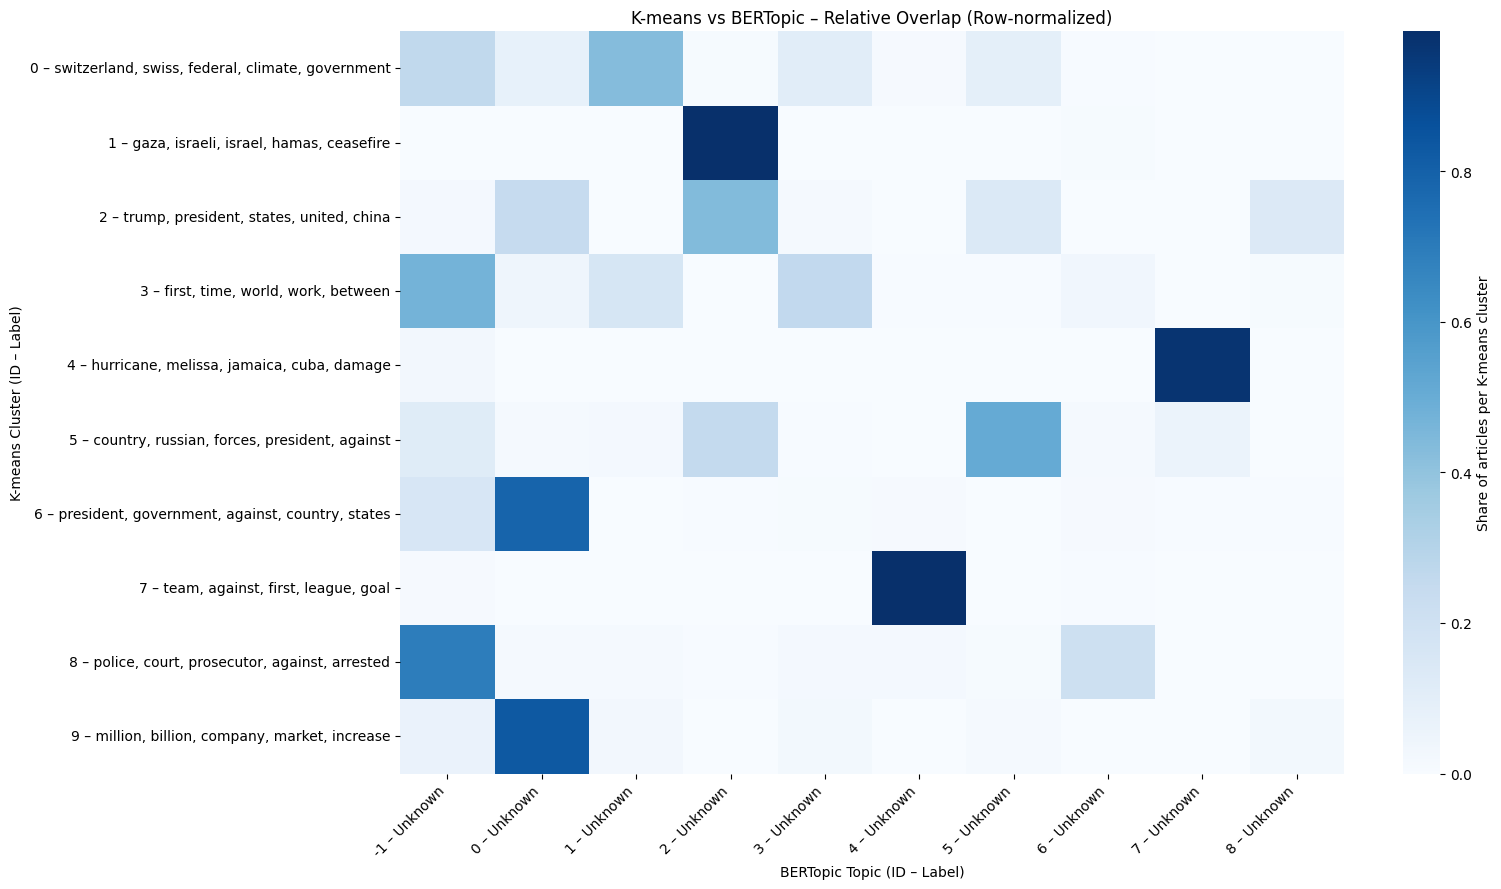

In [0]:
# Optional: falls noch nicht gemacht, sicherstellen, dass topic_labels_en int-Keys hat
topic_labels_en = {int(k): v for k, v in topic_labels_en.items()}

def make_kmeans_keyword_label(cluster_id, topic_labels_en, top_k=5):
    raw = topic_labels_en.get(cluster_id, "")
    
    # raw kann Liste oder String sein
    if isinstance(raw, (list, tuple)):
        keywords = [str(w) for w in raw][:top_k]
    elif isinstance(raw, str):
        parts = [p.strip() for p in raw.split(",") if p.strip()]
        keywords = parts[:top_k]
    else:
        keywords = [str(raw)]
        
    return ", ".join(keywords)


# Crosstab K-means x BERTopic
crosstab = pd.crosstab(
    df_merged['kmeans_cluster'],
    df_merged['bertopic_topic']
)

# K-means labels: "0 – swiss, politics, climate, ..." (Top-5 Keywords)
kmeans_id_to_label = {
    cid: f"{cid} – {make_kmeans_keyword_label(cid, topic_labels_en)}"
    for cid in sorted(df_merged['kmeans_cluster'].dropna().unique())
}

# BERTopic labels: "3 – Gaza, Israel, war, ..." (aus bertopic_pretty_labels)
bertopic_id_to_label = {
    tid: f"{tid} – {bertopic_pretty_labels.get(tid, 'Unknown')}"
    for tid in sorted(df_merged['bertopic_topic'].dropna().unique())
}

# Normalisieren (Zeilenweise)
crosstab_norm = crosstab.div(crosstab.sum(axis=1), axis=0)

# Achsen mit Labels umbenennen
crosstab_norm_labeled = crosstab_norm.rename(
    index=kmeans_id_to_label,
    columns=bertopic_id_to_label
)

plt.figure(figsize=(16, 9))
sns.heatmap(
    crosstab_norm_labeled,
    cmap="Blues",
    annot=False,
    cbar_kws={"label": "Share of articles per K-means cluster"}
)
plt.title("K-means vs BERTopic – Relative Overlap (Row-normalized)")
plt.xlabel("BERTopic Topic (ID – Label)")
plt.ylabel("K-means Cluster (ID – Label)")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


The heatmap shows the relative overlap between K-means clusters and BERTopic topics. Overall, the results indicate that both models agree well on highly cohesive themes but differ more strongly on broad or multi-dimensional topics.

1. Strong matches: Several K-means clusters map almost perfectly to a single BERTopic topic. This includes:
- Middle East conflict (K-means 1 → BERTopic 2)
- Russia–Ukraine war (K-means 5 → BERTopic 5)
- Sports (K-means 7 → BERTopic 4)
- Crime and justice (K-means 8 → BERTopic 6)
- Hurricanes (K-means 4 → BERTopic 7)

These topics are very coherent, with clear vocabulary, which makes them easy for both algorithms to detect consistently.

2. Partial alignment: Some clusters show moderate overlap across multiple BERTopic topics. Examples:
- Swiss domestic politics (K-means 0), which maps mostly to BERTopic 1 but with noticeable spillover.
- US–China geopolitics (K-means 2), which spans BERTopic 0 (international diplomacy) and BERTopic 8 (US domestic politics). K-means merges these, while BERTopic separates them.

This indicates that these domains have internal substructure that BERTopic picks up more clearly.

3. Divergence on heterogeneous categories:
- Global culture and human-interest stories (K-means 3) are distributed across several BERTopic topics, suggesting diverse vocabulary and weak semantic cohesion.
- Latin American politics (K-means 6) maps largely to BERTopic topic -1 (outliers), meaning BERTopic does not find a stable cluster for this region.
- Global economy (K-means 9) maps partially to political topics in BERTopic, implying economic reporting is often embedded in political narratives rather than forming its own semantic group.

4. Overall conclusion: Both models detect a similar core of strong topics (conflicts, crime, sports, disasters), but BERTopic reveals more fine-grained distinctions within political themes, while K-means produces broader, more general categories. BERTopic is more sensitive to contextual and linguistic subtleties, whereas K-means is more stable for high-level thematic groupings.

### 5.3.3 A more sofisiticated approach using overlap metrics

In [0]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

# Drop outliers (if BERTopic labels -1 exist)
df_eval = df_merged.dropna(subset=['kmeans_cluster', 'bertopic_topic'])

ari = adjusted_rand_score(df_eval['kmeans_cluster'], df_eval['bertopic_topic'])
nmi = normalized_mutual_info_score(df_eval['kmeans_cluster'], df_eval['bertopic_topic'])

print("=== Agreement Metrics ===\n")
print(f"Adjusted Rand Index (ARI): {ari:.4f}")
print(f"Normalized Mutual Information (NMI): {nmi:.4f}")


=== Agreement Metrics ===

Adjusted Rand Index (ARI): 0.3125
Normalized Mutual Information (NMI): 0.5002


#### Key Findings 
The agreement between K-means and BERTopic can be quantified using two standard clustering similarity metrics:

- **Adjusted Rand Index (ARI): 0.31**  
  This value indicates *moderate agreement*. An ARI close to 0 means almost random similarity, while 1.0 represents identical clusterings.  
  An ARI of 0.31 shows that both models partially agree on the structure of the data, but also differ substantially—consistent with the fact that K-means produces broader clusters while BERTopic identifies more fine-grained subtopics.

- **Normalized Mutual Information (NMI): 0.50**  
  This reflects *medium information overlap* between the two methods.  
  An NMI of 0.50 suggests that roughly half of the topical structure found by one method is shared by the other. This is typical when comparing a coarse clustering method (K-means) with a more granular one (BERTopic).

**Overall:**  
The numbers confirm that the two models detect a similar general thematic landscape, but they diverge in how they draw boundaries—K-means merges broader themes, whereas BERTopic splits them into more specific, semantically coherent topics.


# Appendix

## Technical Details

### Models Used
- **Semantic Search & K-means**: `sentence-transformers/all-MiniLM-L6-v2`
- **BERTopic**: `nvidia/llama-embed-nemotron-8b`
- **Translation**: Google Translate API

### Libraries
- pandas, numpy: Data manipulation
- sentence-transformers: Text embeddings
- scikit-learn: K-means clustering
- umap-learn: Dimensionality reduction
- BERTopic: Advanced topic modeling
- hdbscan: Density-based clustering
- matplotlib, seaborn: Visualization
- transformers: HuggingFace models

### Parameters

**UMAP:**
- n_neighbors: 20
- n_components: 5
- min_dist: 0.0
- metric: cosine

**HDBSCAN:**
- min_cluster_size: 220
- min_samples: 15
- metric: euclidean

**K-means:**
- n_clusters: 10
- random_state: 42

## Data Access

**Public Sample:**
- URL: https://github.com/Tao-Pi/CAS-Applied-Data-Science/raw/main/Module-3/01_Module%20Final%20Assignment/export_articles_v2_sample25mb.parquet
- Size: <25MB
- Articles: 1,000 (sampled)

**Full Dataset (Confidential):**
- Location: Databricks Delta table
- Access: Requires SRG SSR credentials

## Resources

- [RenkuLab](https://renkulab.io) - Cloud-based Jupyter environment
- [BERTopic Documentation](https://maartengr.github.io/BERTopic/)
- [Sentence Transformers](https://www.sbert.net/)

## Contact

For questions about this analysis or data access, contact the SRG SSR data team.

---

**Analysis Date:** November 2025  
**Notebook Version:** 1.0 (Comprehensive Merged)  
**Authors:** CAS ADS Module 3 Project Team

## Abandoned: Kmeans, without translations)

**Use Case:** Discover what topics SRG writes about to improve navigation and content organization.

**Approach:**
- Use K-means clustering on article embeddings
- Extract representative keywords for each cluster
- Visualize topic distribution in 2D space using UMAP

In [0]:
from sklearn.cluster import KMeans
from collections import Counter
import re
import contextlib
import io

# Perform K-means clustering
n_clusters = 10
print(f"Performing K-means clustering with {n_clusters} clusters...")

kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)

# --- suppress ugly threadpoolctl exceptions printed to stderr ---
stderr_buffer = io.StringIO()
with contextlib.redirect_stderr(stderr_buffer):
    labels = kmeans.fit_predict(emb_matrix.astype(float))
# ----------------------------------------------------------------

df_clusters = srgssr_article_corpus.DataFrame({
    "id": ids,
    "content_text_csv": texts,
    "cluster": labels
})

def get_topic_keywords(cluster_id, df_clusters, top_n=3):
    """Extract most common meaningful words from articles in a cluster"""
    cluster_texts = df_clusters[df_clusters['cluster'] == cluster_id]['content_text_csv'].tolist()
    combined_text = ' '.join(cluster_texts).lower()
    words = re.findall(r'\b[a-zäöüàéèêëïôùû]{4,}\b', combined_text)
    
    stopwords = {
        'dass', 'sind', 'wird', 'wurden', 'wurde', 'haben', 'sein',
        'eine', 'einem', 'einen', 'einer', 'dies', 'diese', 'dieser',
        'auch', 'mehr', 'beim', 'über', 'nach', 'sich', 'oder', 'kann',
        'können', 'müssen', 'soll', 'sollen', 'noch', 'bereits', 'aber',
        'wenn', 'weil', 'denn', 'dann', 'sowie', 'dass', 'damit', 'with',
        'from', 'have', 'this', 'that', 'will', 'been', 'were', 'their',
        'what', 'which', 'when', 'where', 'there', 'pour', 'dans', 'avec',
        'sont', 'être', 'cette', 'mais', 'plus', 'comme', 'fait'
    }
    
    words = [w for w in words if w not in stopwords]
    word_counts = Counter(words)
    top_words = [word for word, count in word_counts.most_common(top_n)]
    return ', '.join(top_words) if top_words else f"Topic {cluster_id}"

# Generate topic labels
topic_labels = {}
for cluster_id in range(n_clusters):
    topic_labels[cluster_id] = get_topic_keywords(cluster_id, df_clusters, top_n=3)

df_clusters['cluster_topic'] = df_clusters['cluster'].map(topic_labels)

print("Finished clustering & topic extraction.")

Performing K-means clustering with 10 clusters...


---------------------------------------------------------------------------
AttributeError                            Traceback (most recent call last)
~/.ipykernel/103708/command-8601364276573286-2382814652 in ?()
     15 with contextlib.redirect_stderr(stderr_buffer):
     16     labels = kmeans.fit_predict(emb_matrix.astype(float))
     17 # ----------------------------------------------------------------
     18 
---> 19 df_clusters = srgssr_article_corpus.DataFrame({
     20     "id": ids,
     21     "content_text_csv": texts,
     22     "cluster": labels

/databricks/python/lib/python3.10/site-packages/pandas/core/generic.py in ?(self, name)
   5898             and name not in self._accessors
   5899             and self._info_axis._can_hold_identifiers_and_holds_name(name)
   5900         ):
   5901             return self[name]
-> 5902         return object.__getattribute__(self, name)

AttributeError: 'DataFrame' object has no attribute 'DataFrame'

In [0]:
print("\nCluster Topics (K-means):")
print("="*80)
for cluster_id in range(n_clusters):
    count = len(df_clusters[df_clusters['cluster'] == cluster_id])
    print(f"Cluster {cluster_id}: {topic_labels[cluster_id]} ({count} articles)")

print("\nSome examples:")
print("="*80)

examples = df_clusters.groupby("cluster").head(1)  # 1 example per cluster

for _, row in examples.iterrows():
    print(f"ID: {row['id']}")
    print(f"Cluster: {row['cluster']} | Topic: {row['cluster_topic']}")
    print(f"URL: https://www.swissinfo.ch/s/{row['id'].split(':')[-1]}")
    print(f"Text: {row['content_text_csv'][:400]}...")
    print("-" * 80)


## Visualize K-means Clusters

In [0]:
print("Creating UMAP projection for visualization...")
reducer = UMAP(n_components=2, random_state=42, n_neighbors=15, min_dist=0.1)
embedding_2d = reducer.fit_transform(emb_matrix)

# Create scatter plot
plt.figure(figsize=(16, 12))
scatter = plt.scatter(
    embedding_2d[:, 0], 
    embedding_2d[:, 1], 
    c=labels, 
    cmap='tab10', 
    alpha=0.6, 
    s=50
)

plt.colorbar(scatter, label='Cluster')
plt.title('K-means Topic Clusters Visualization (UMAP Projection)', fontsize=16)
plt.xlabel('UMAP Dimension 1', fontsize=12)
plt.ylabel('UMAP Dimension 2', fontsize=12)
plt.grid(True, alpha=0.3)

# Add cluster centers with labels
kmeans_centers_2d = reducer.transform(kmeans.cluster_centers_)
plt.scatter(
    kmeans_centers_2d[:, 0], 
    kmeans_centers_2d[:, 1], 
    c='red', 
    marker='X', 
    s=200, 
    edgecolors='black', 
    linewidths=2,
    label='Cluster Centers'
)

# Add text labels
for cluster_id in range(n_clusters):
    x, y = kmeans_centers_2d[cluster_id]
    label_text = f"C{cluster_id}: {topic_labels[cluster_id]}"
    plt.annotate(
        label_text,
        xy=(x, y),
        xytext=(10, 10),
        textcoords='offset points',
        fontsize=9,
        bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.7),
        arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0', color='black', lw=1)
    )

plt.legend()
plt.tight_layout()
plt.show()

# Print cluster distribution
print("\nK-means Cluster Distribution:")
cluster_counts = df_clusters['cluster'].value_counts().sort_index()
for cluster_id, count in cluster_counts.items():
    print(f"Cluster {cluster_id} ({topic_labels[cluster_id]}): {count} articles")